# Почистим данные перед визуализацией

На момент скачивания таблицы была ночь с 4 февраля на 5 февраля, тогда было 2531 запись, добавляются они в начало, поэтому беру количество записей с (количество всех записей - 2531) элемента

In [141]:
import pandas as pd
from ztfquery import lightcurve
import time
import numpy as np
from tqdm import tqdm
from PyAstronomy import pyasl
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib
from matplotlib import pyplot as plt


EPS = 0.5


path = "https://sites.astro.caltech.edu/ztf/bts/explorer.php?f=s&subsample=trans&classstring=&classexclude=&quality=y&purity=y&ztflink=lasair&lastdet=&startsavedate=&startpeakdate=&startra=&startdec=&startz=&startdur=&startrise=&startfade=&startpeakmag=&startabsmag=&starthostabs=&starthostcol=&startb=&startav=&endsavedate=&endpeakdate=&endra=&enddec=&endz=&enddur=&endrise=&endfade=&endpeakmag=19.0&endabsmag=&endhostabs=&endhostcol=&endb=&endav=&reverse=y&format=csv"
df_ztf = pd.read_csv(path, sep =',')
count_row = df_ztf.index.values.shape[0]
df_ztf = df_ztf[(count_row-2531):]
df_ztf.to_csv("/home/masha/AstroAugumetation/ZTF_BTS.csv")

path_df = '/home/masha/AstroAugumetation/DataFrames'
df_clean = []
numbers = []
peaks_without_matching_g = []
date_without_matching_g = []
peaks_without_matching_r = []
date_without_matching_r = []
for i in range(0, 2531):
    
    try:
        data = pd.read_csv(path_df+"/{}.csv".format(i), sep =',')
        #оставим только данные с положительными ошибками и catflags = 0
        data = data[(data['magerr'] > 0) & (data['catflags'] == 0)]
        
        #непустые датафреймы смотрим далее
        if data.index.values.shape[0] != 0:
            peak_date = np.round(df_ztf[:(i+1)]['peakt'].values[i], 3)
            ra = df_ztf[:(i+1)]['RA'].values[i]
            dec = df_ztf[:(i+1)]['Dec'].values[i]
            ra_dec = SkyCoord(' '.join([ra, dec]), unit=(u.hourangle, u.deg))
            mjd = pyasl.helio_jd(peak_date + 2458000 - 2.4e6, ra_dec.ra.deg, ra_dec.dec.deg)
            #проверим, что дата пика (с точностью до дня) попадает в датафрейм
            if np.any(np.round(mjd, 0) in np.round(data['mjd'].values, 0)):
                df_clean.append(data)
                numbers.append(i)
                path_new = "/home/masha/AstroAugumetation/DataFramesClean"
                data.to_csv(path_new + "/{}.csv".format(i))
            #далее идёт проверка, что звездная величина пика+-0.5 попадает в скачанный датафрейм
#                 try:
#                     peak_g = np.round(df_ztf['peakmag'][df_ztf['peakfilt'] == 'g'].loc[i+(count_row-2531)], 3)
#                     magnitudes_g = np.round(data['mag'][data['filtercode'] == 'zg'].values, 3)
#                     mask_g = (magnitudes_g > peak_g - EPS) & (magnitudes_g < peak_g + EPS)
#                     if not np.any(mask_g):
#                         peaks_without_matching_g.append(peak_g)
#                         date_without_matching_g.append(np.round(mjd, 0))
#                         df_clean.append(data)
#                         numbers.append(i)
#                 except KeyError: 
#                     continue
#                 try:
#                     peak_r = np.round(df_ztf['peakmag'][df_ztf['peakfilt'] == 'r'].loc[i+(count_row-2531)], 3)
#                     magnitudes_r = np.round(data['mag'][data['filtercode'] == 'zr'].values, 3)
#                     mask_r = (magnitudes_r > peak_r - EPS) & (magnitudes_r < peak_r + EPS)
#                     if not np.any(mask_r):
#                         peaks_without_matching_r.append(peak_r)
#                         date_without_matching_r.append(np.round(mjd, 0))
#                         df_clean.append(data)
#                         numbers.append(i)
#                 except KeyError:
#                     continue                    

                
    except FileNotFoundError:
        continue


In [128]:
type(df_ztf['peakmag'][df_ztf['peakfilt'] == 'r'].loc[2000])

numpy.float64

In [103]:
len(df_ztf['ZTFID'].unique())

2531

In [97]:
df_ztf[df_ztf['peakfilt'] == 'i'].index.values.shape

(0,)

In [143]:
len(numbers)

286

In [120]:
print(len(date_without_matching_g), len(date_without_matching_r), len(peaks_without_matching_g), len(peaks_without_matching_r))

50 0 50 0


In [127]:
type(date_without_matching_g[8])

numpy.float64

In [98]:
df_clean[6]['filtercode'].unique()

array(['zg', 'zr', 'zi'], dtype=object)

<ipython-input-142-3df55c398d61>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


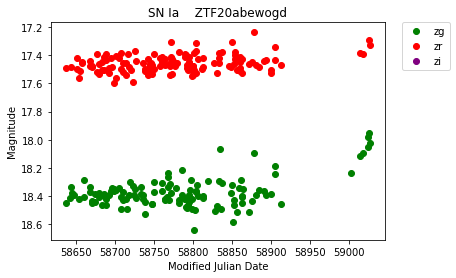

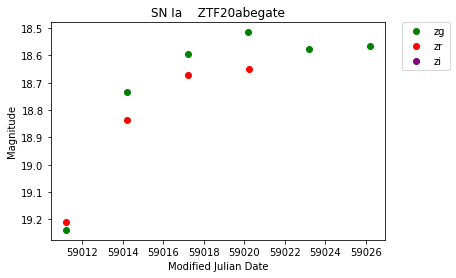

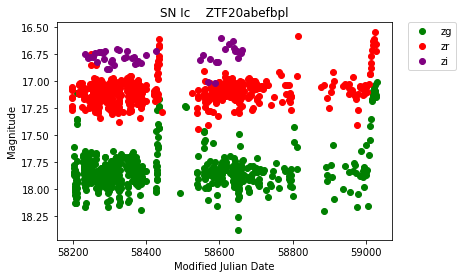

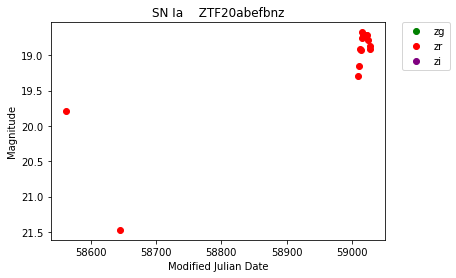

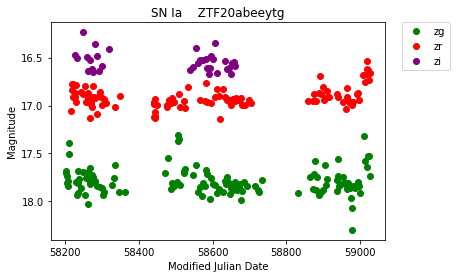

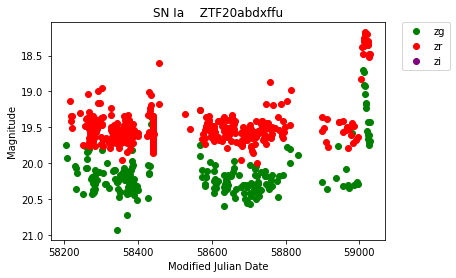

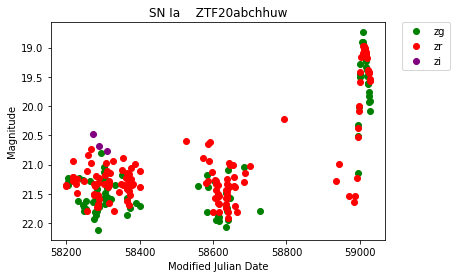

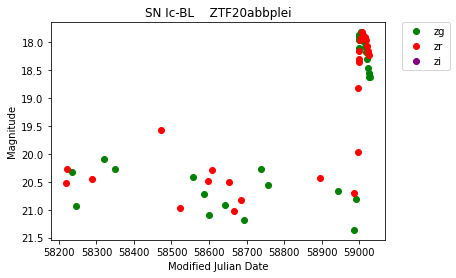

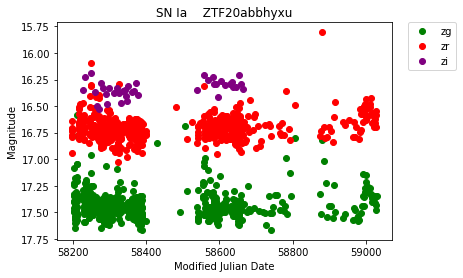

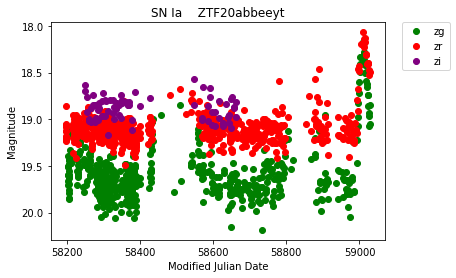

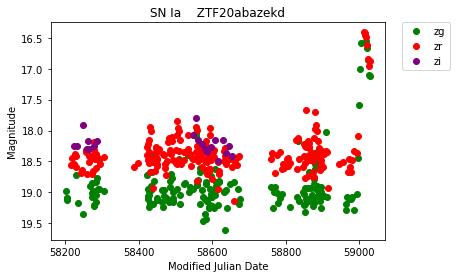

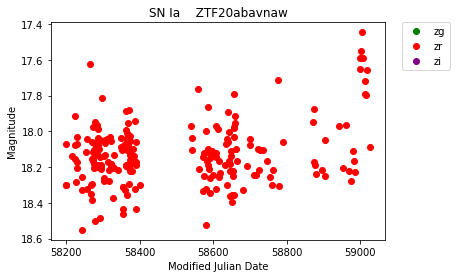

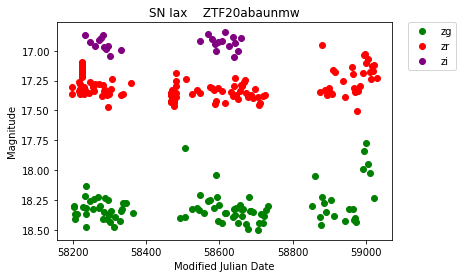

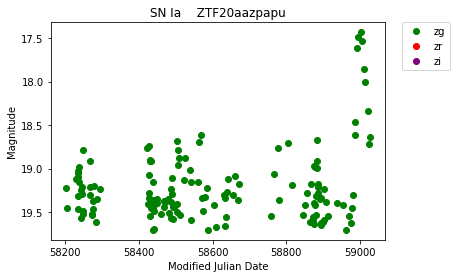

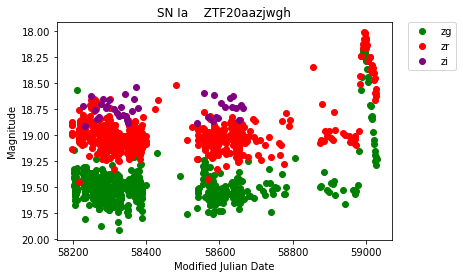

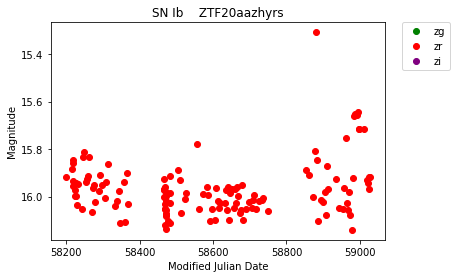

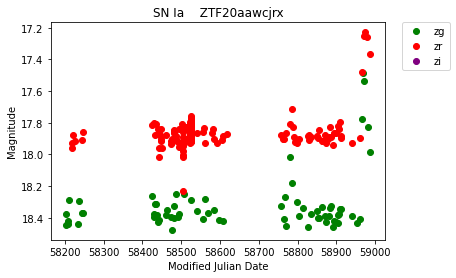

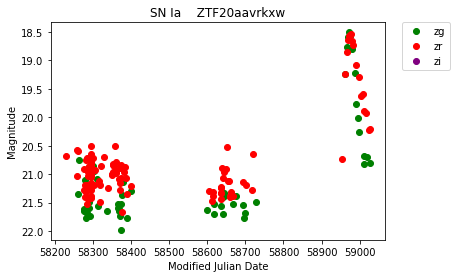

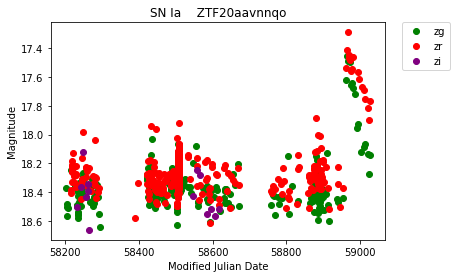

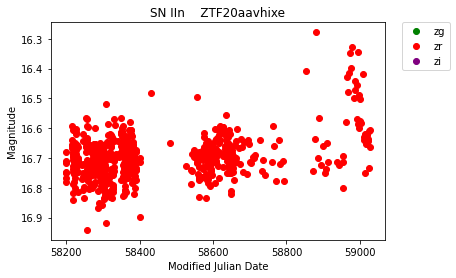

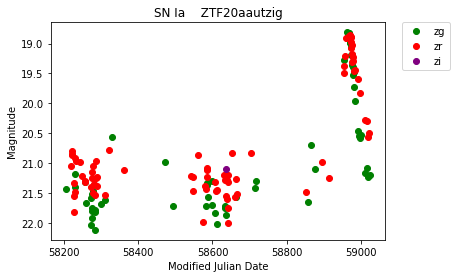

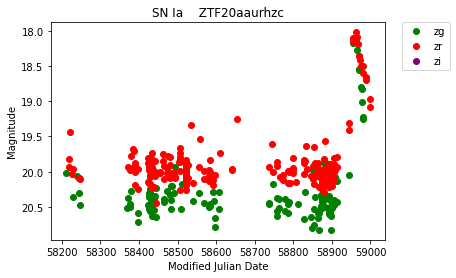

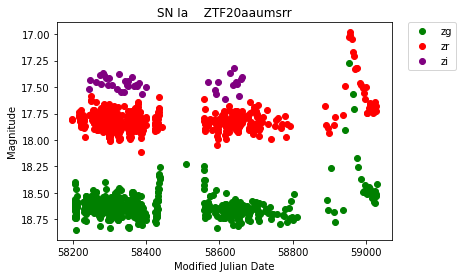

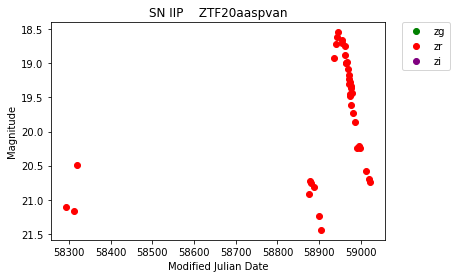

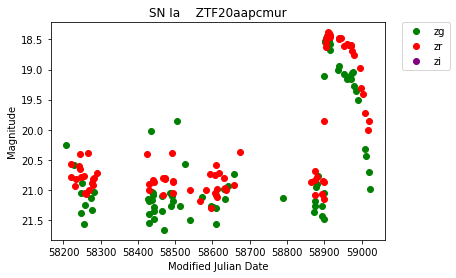

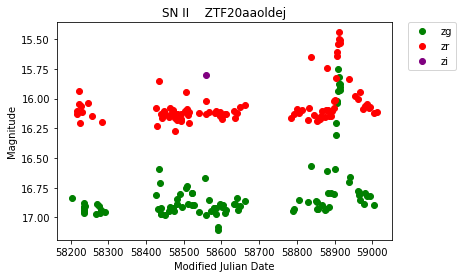

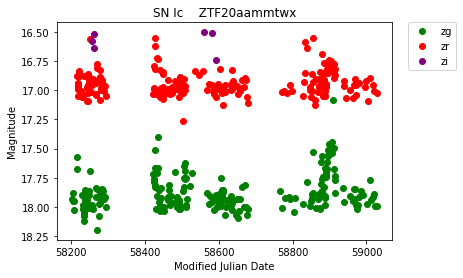

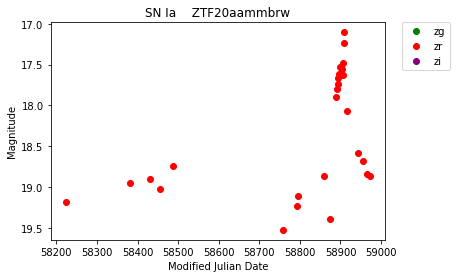

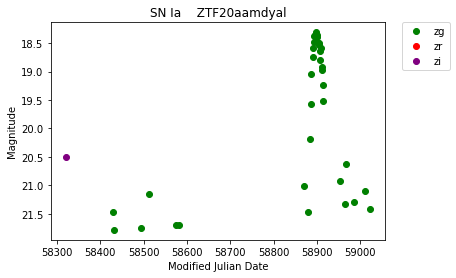

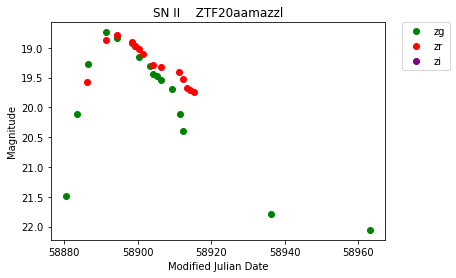

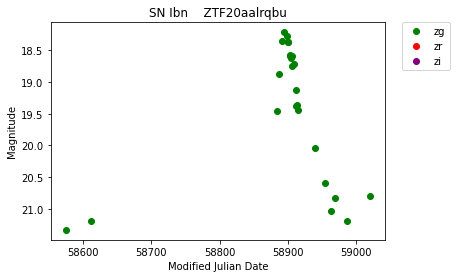

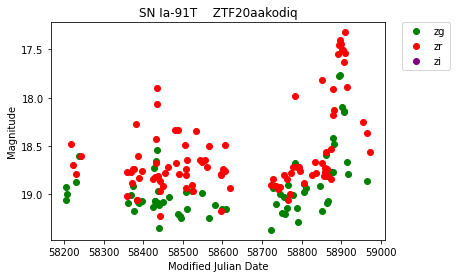

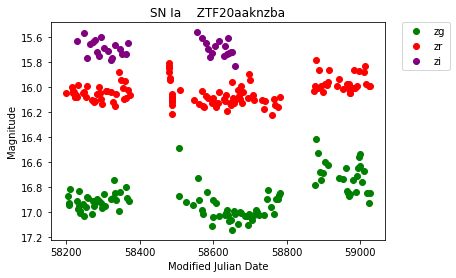

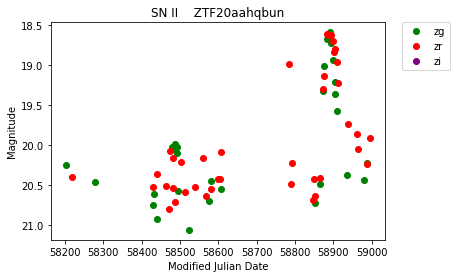

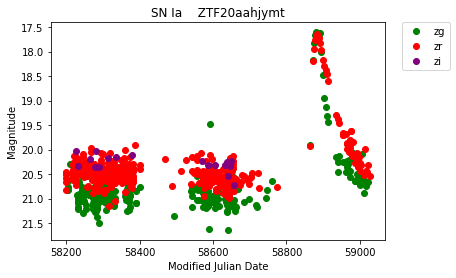

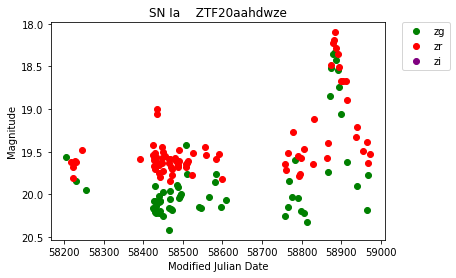

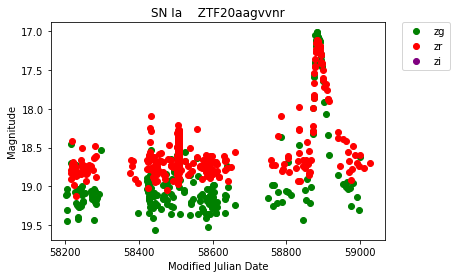

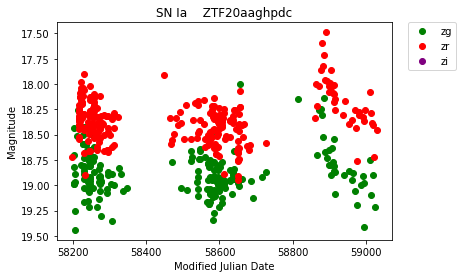

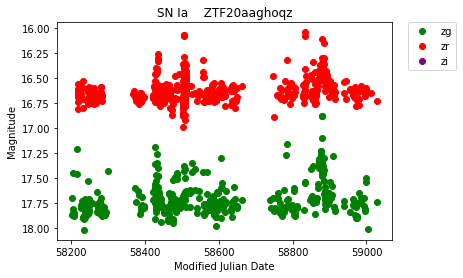

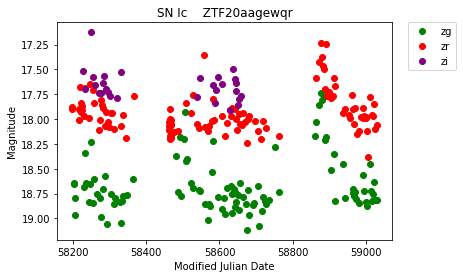

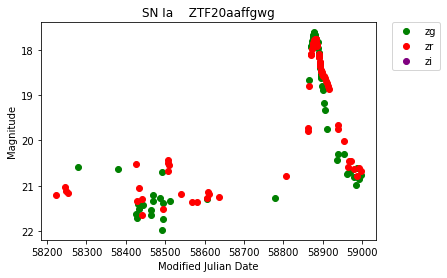

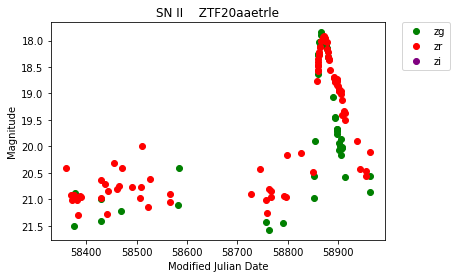

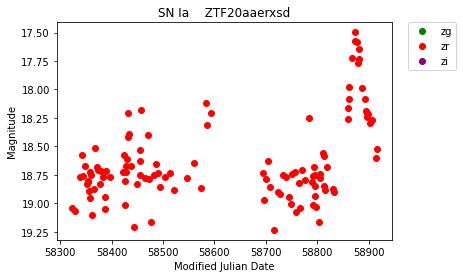

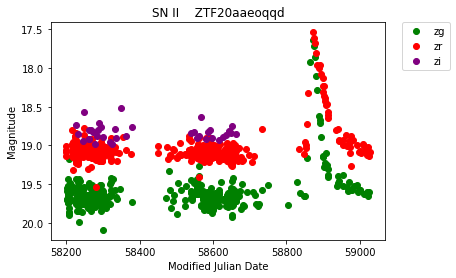

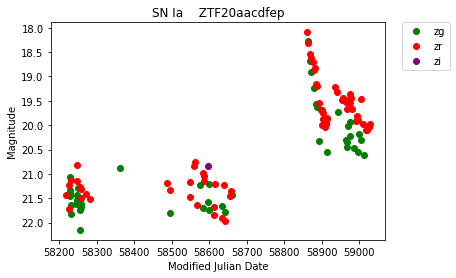

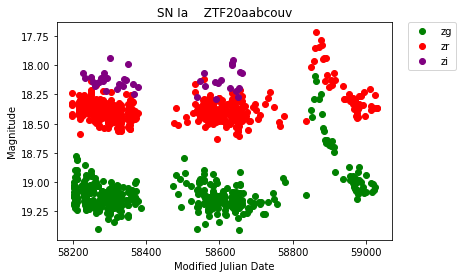

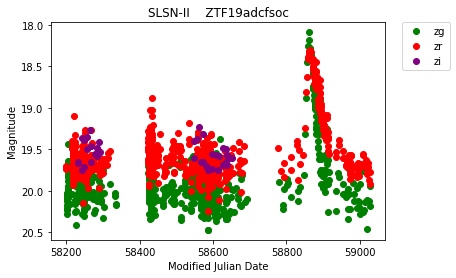

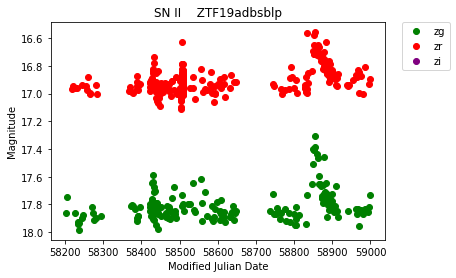

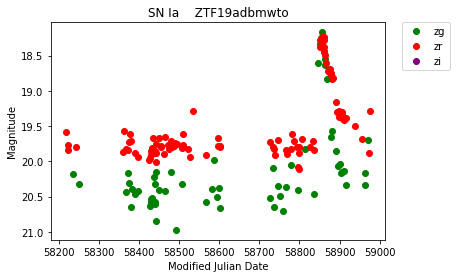

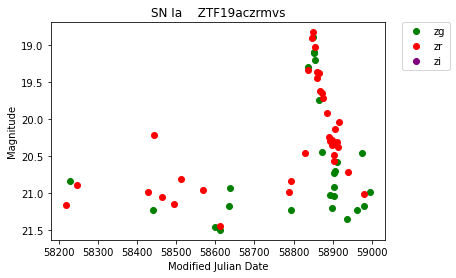

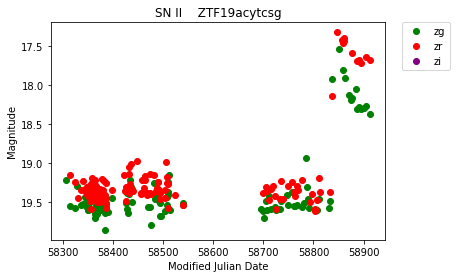

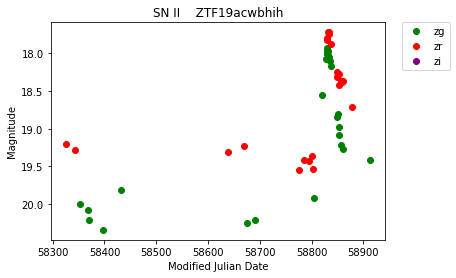

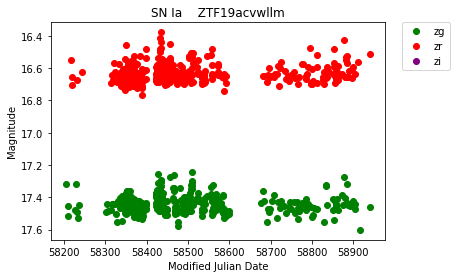

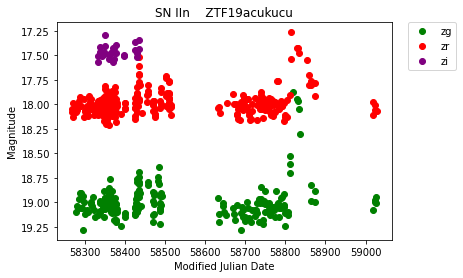

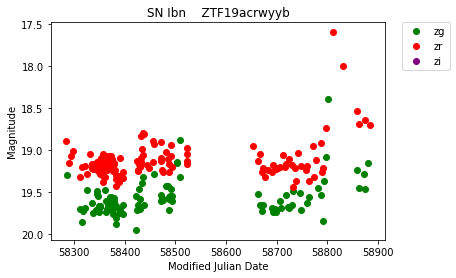

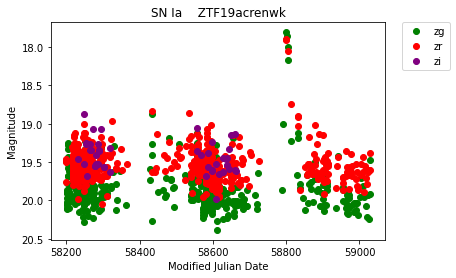

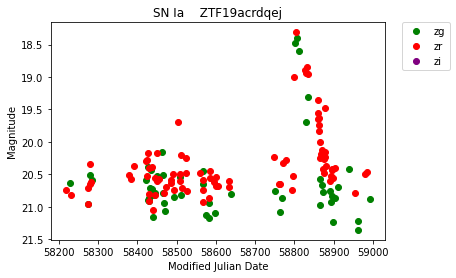

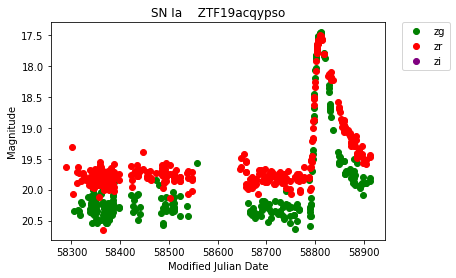

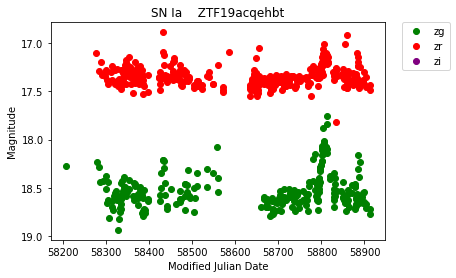

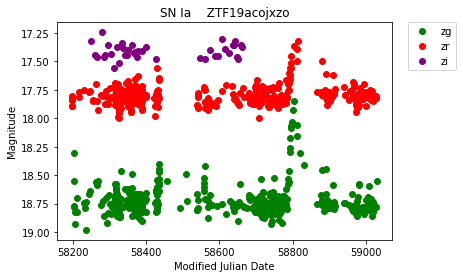

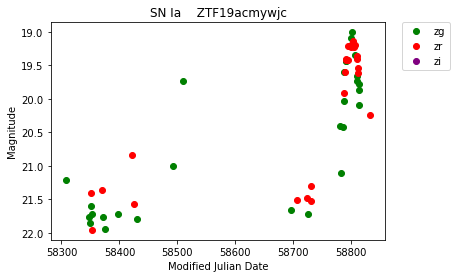

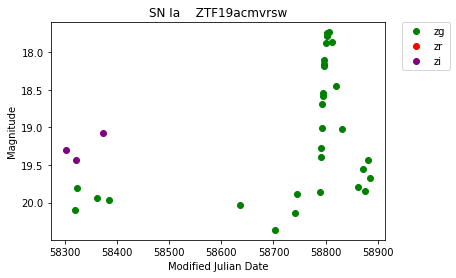

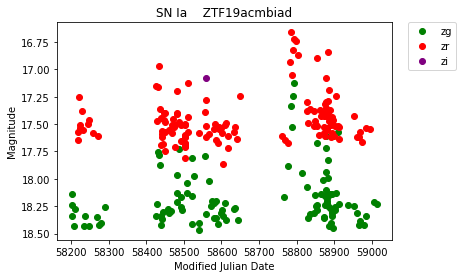

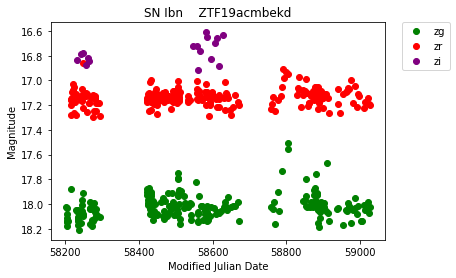

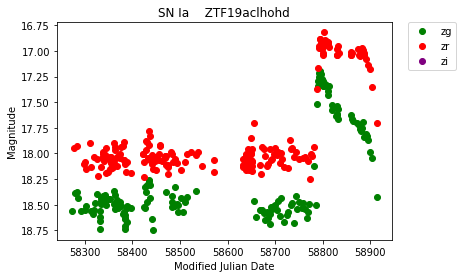

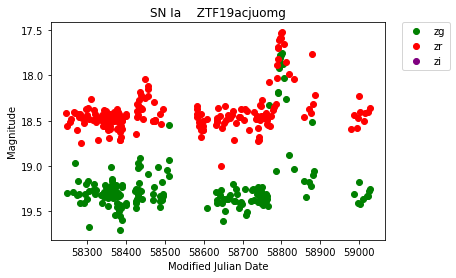

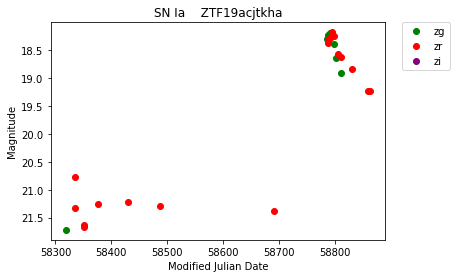

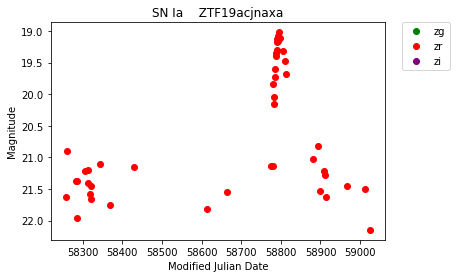

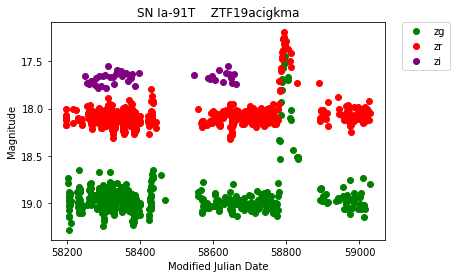

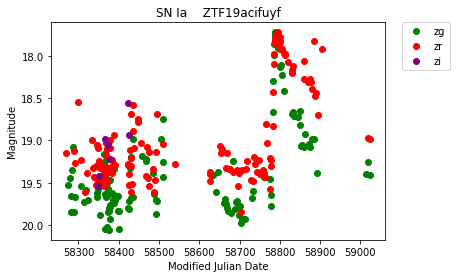

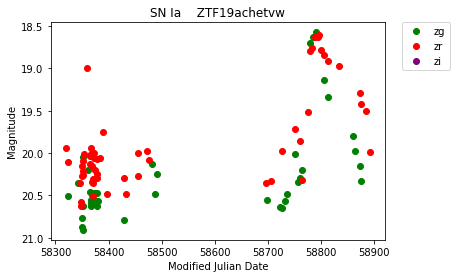

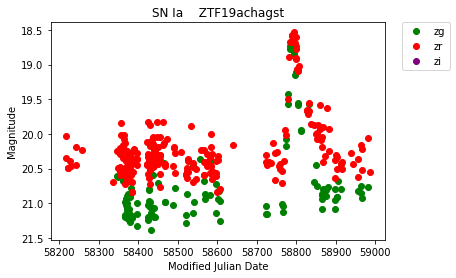

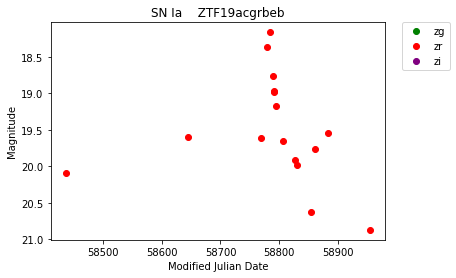

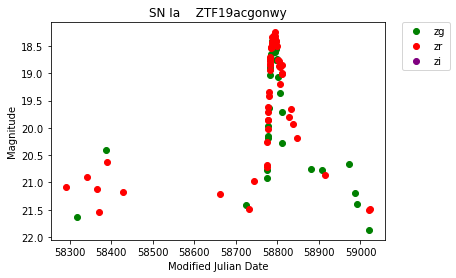

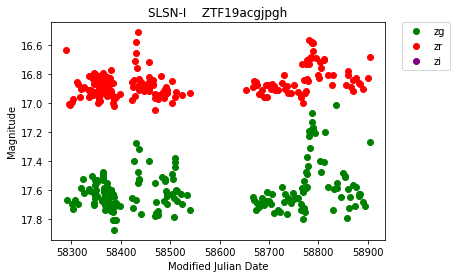

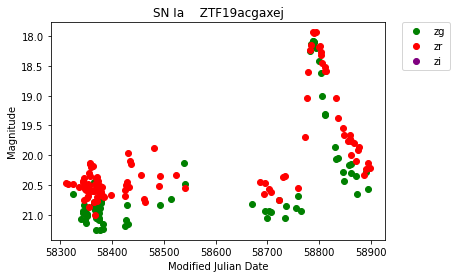

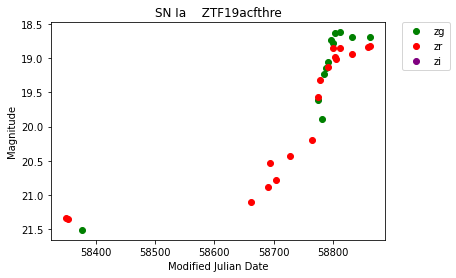

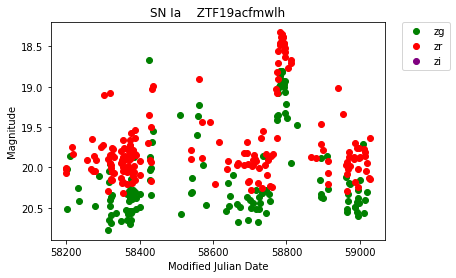

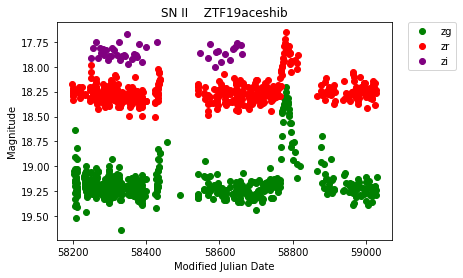

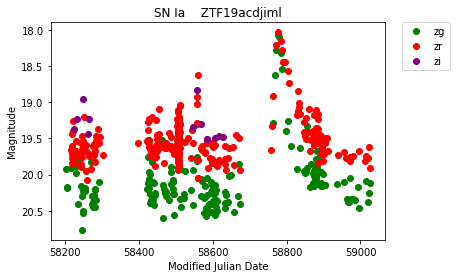

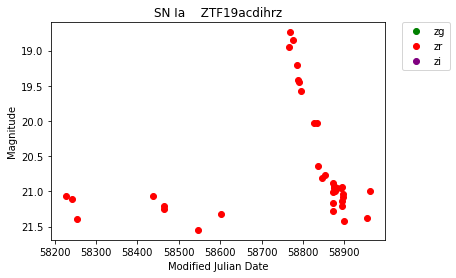

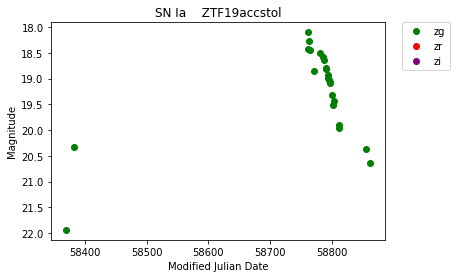

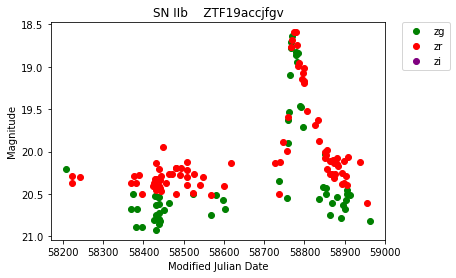

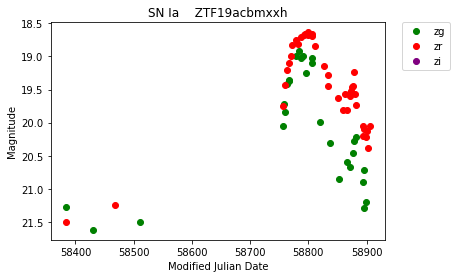

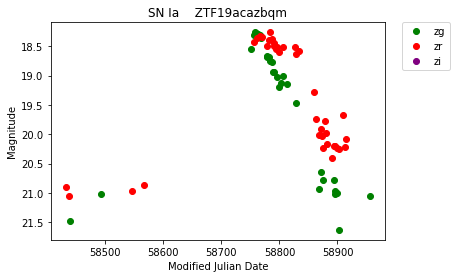

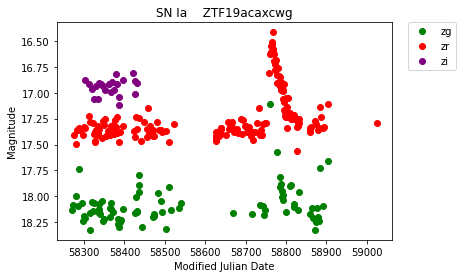

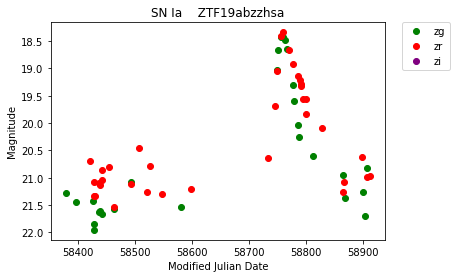

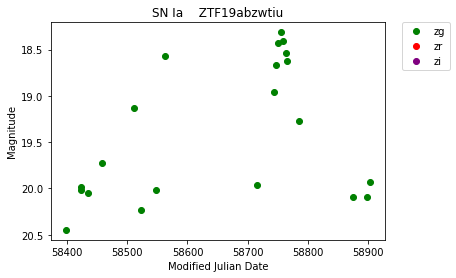

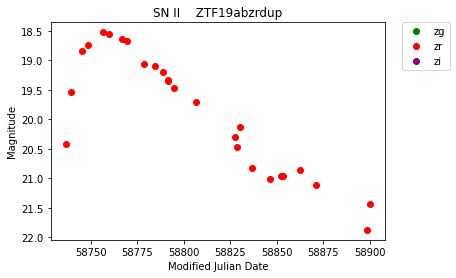

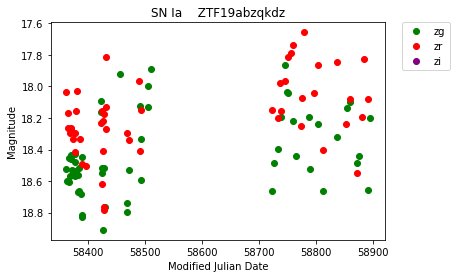

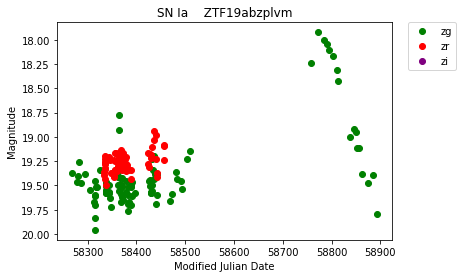

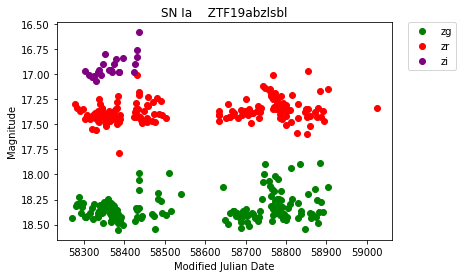

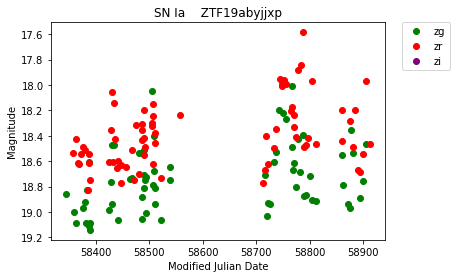

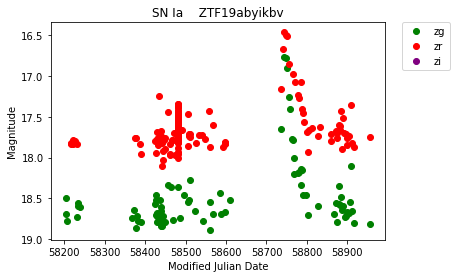

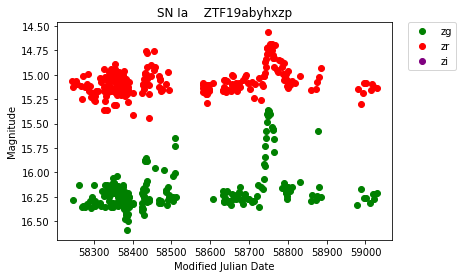

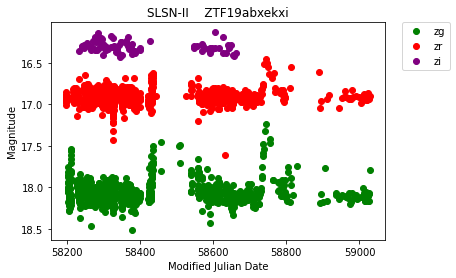

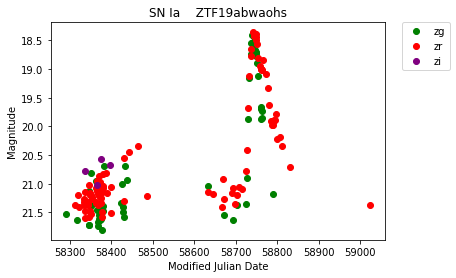

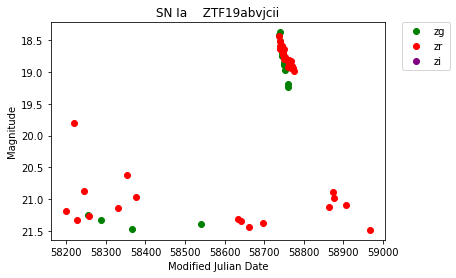

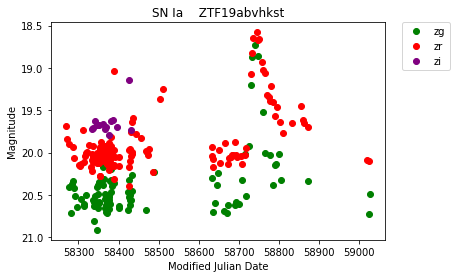

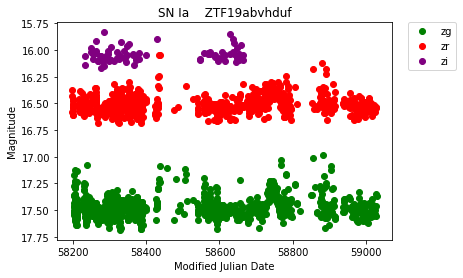

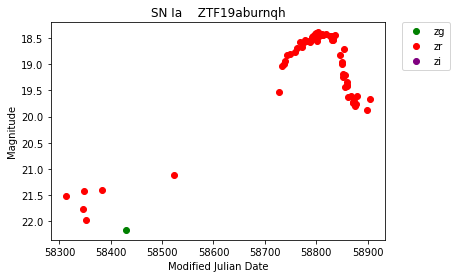

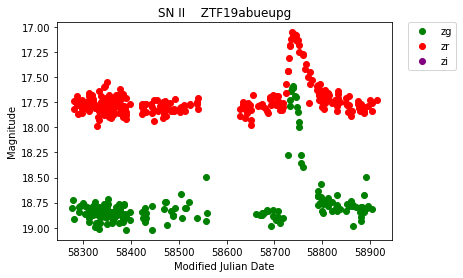

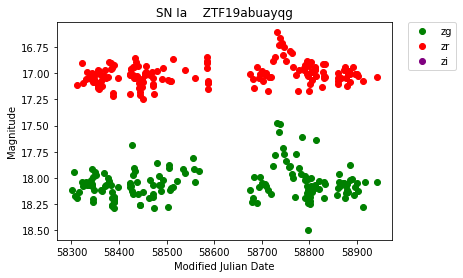

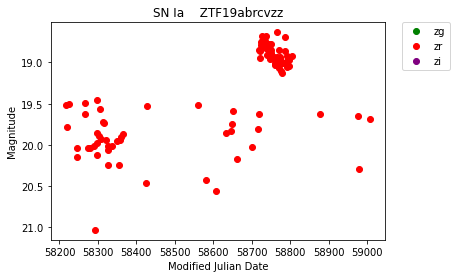

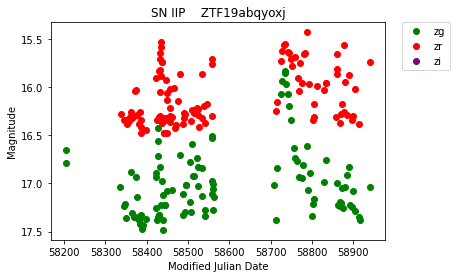

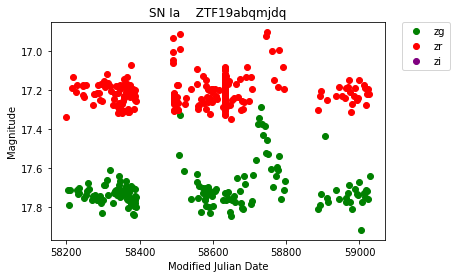

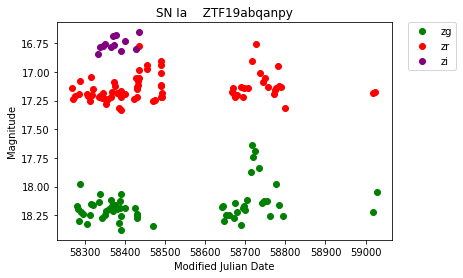

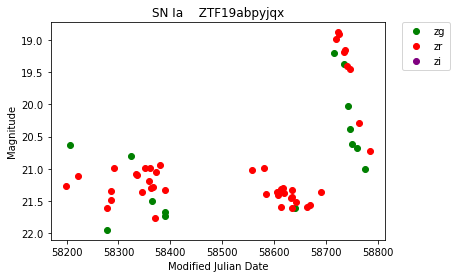

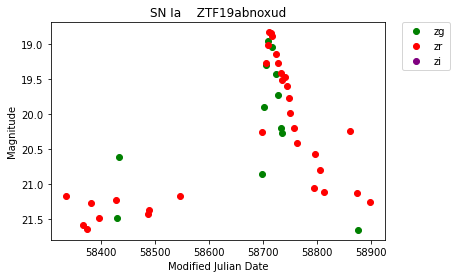

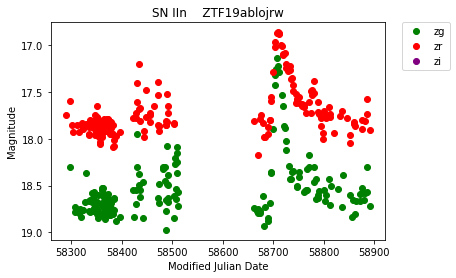

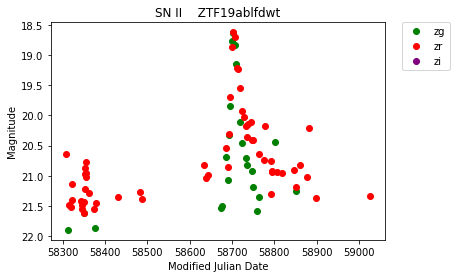

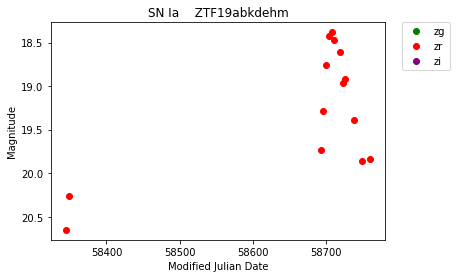

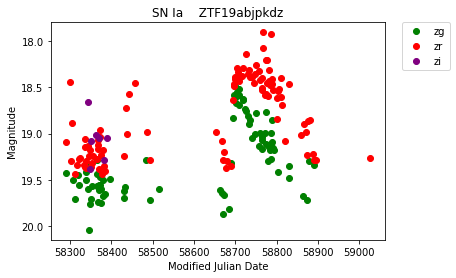

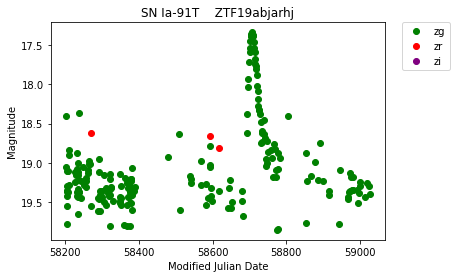

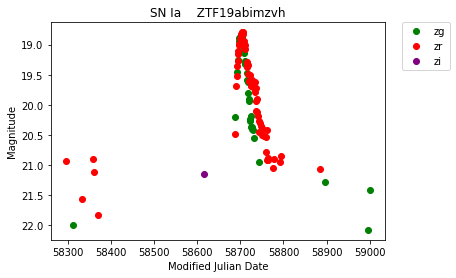

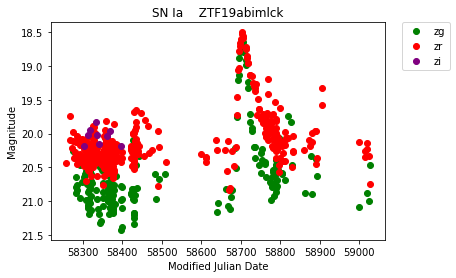

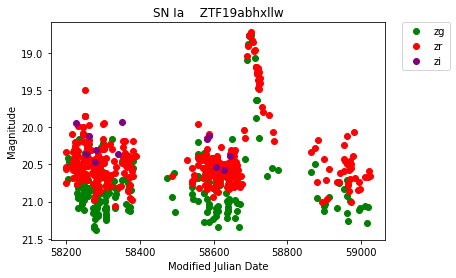

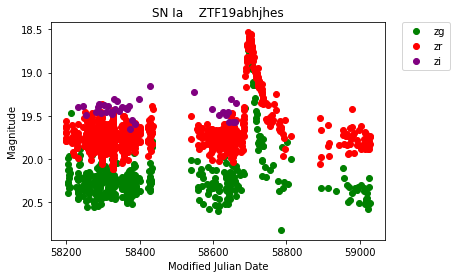

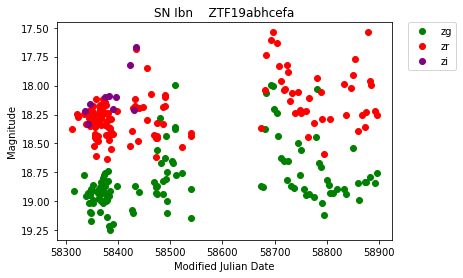

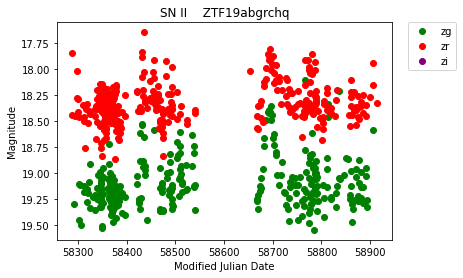

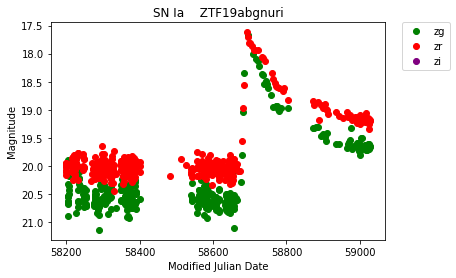

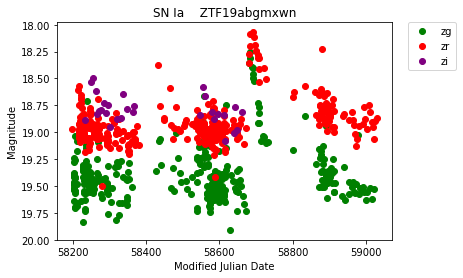

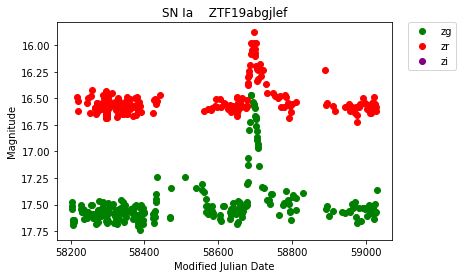

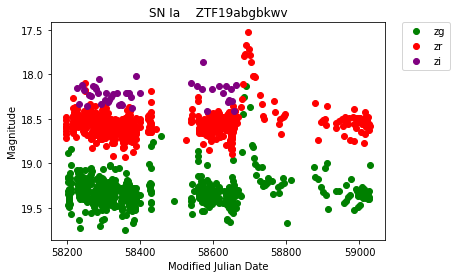

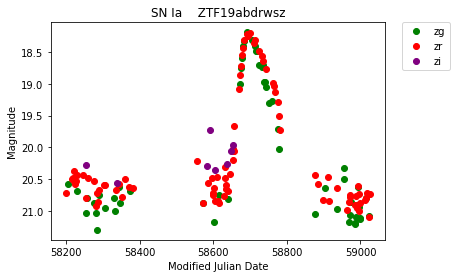

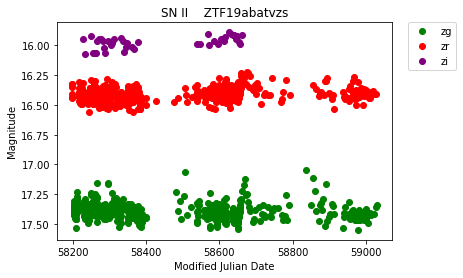

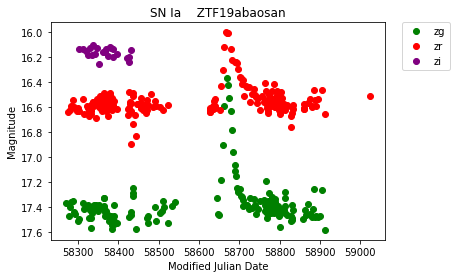

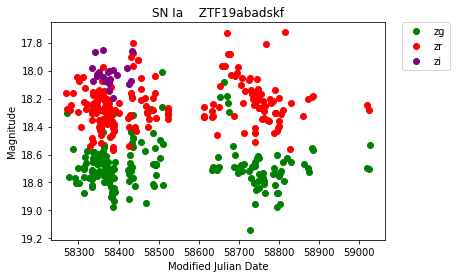

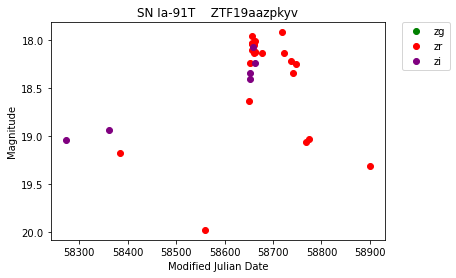

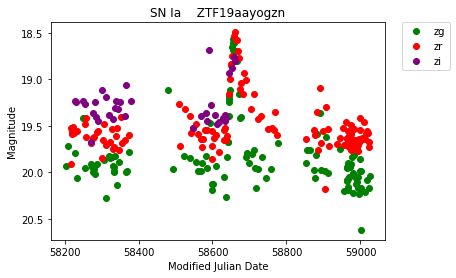

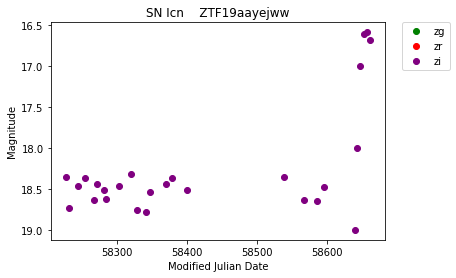

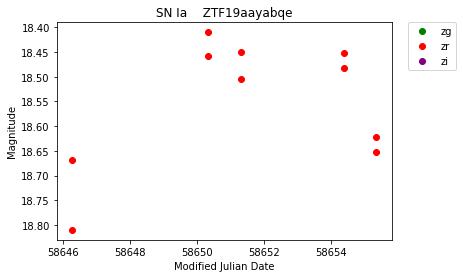

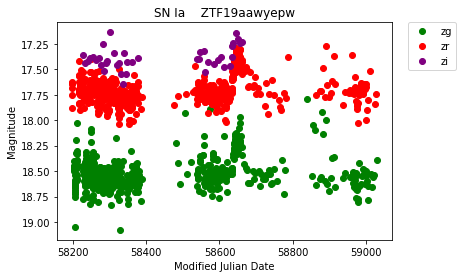

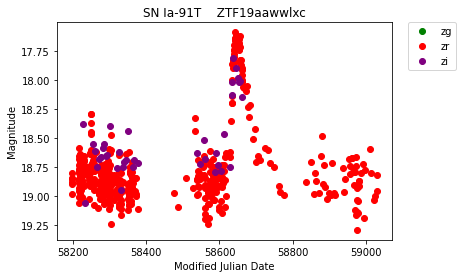

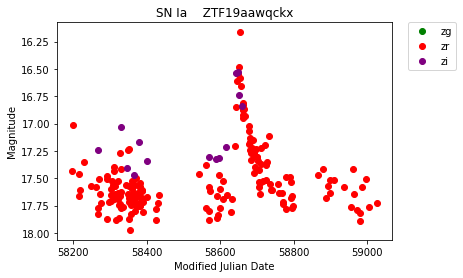

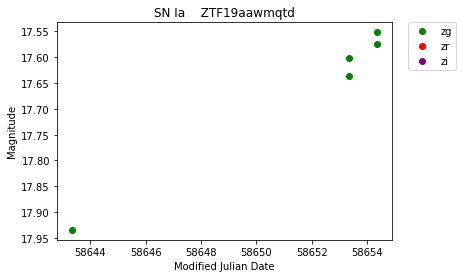

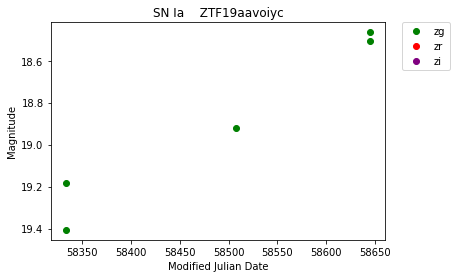

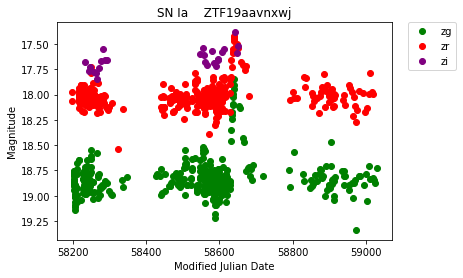

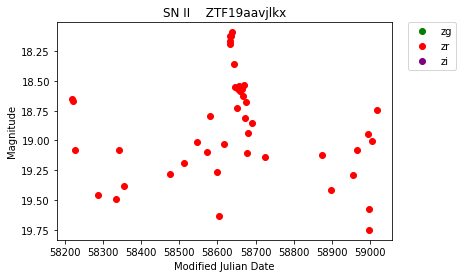

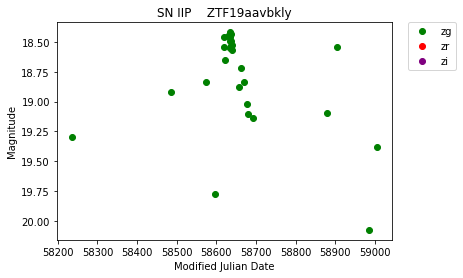

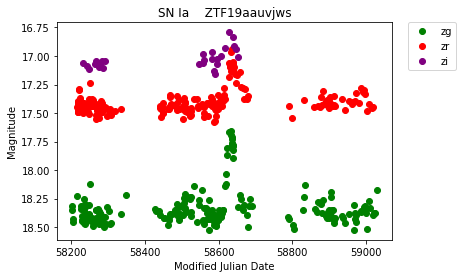

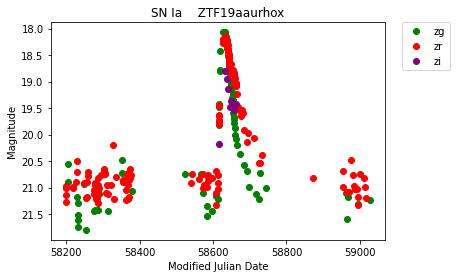

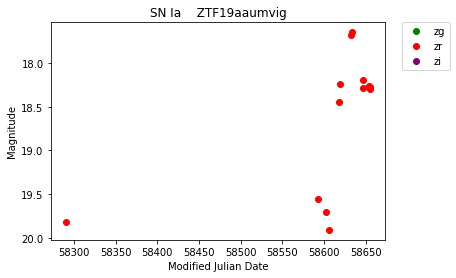

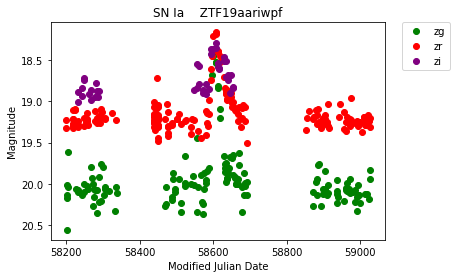

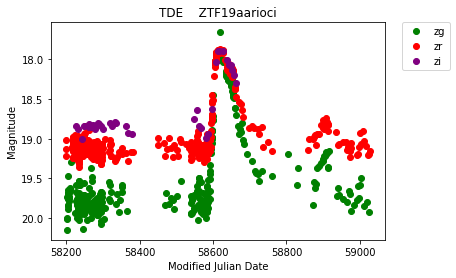

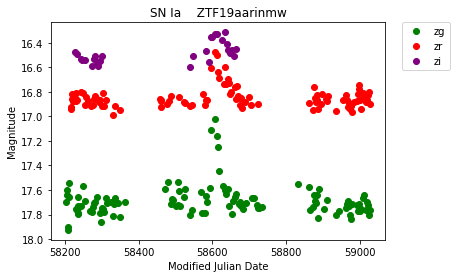

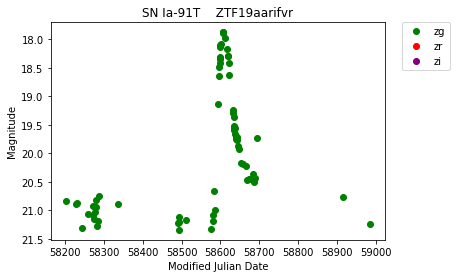

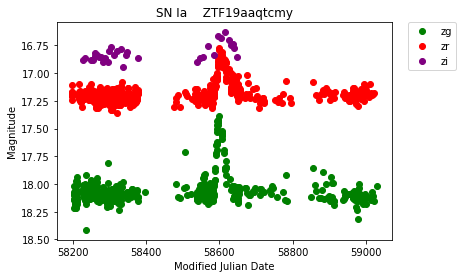

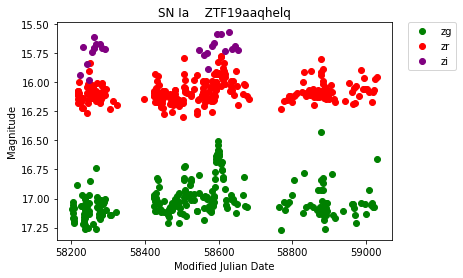

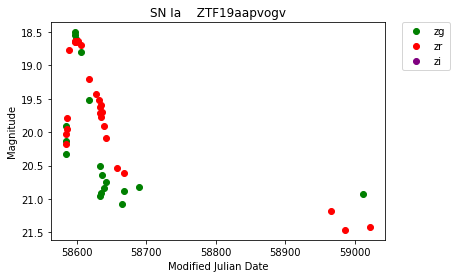

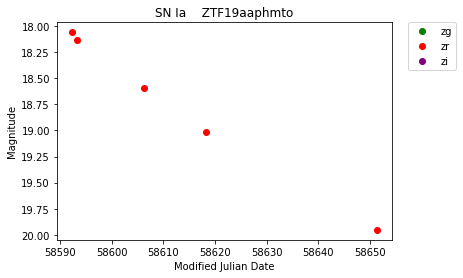

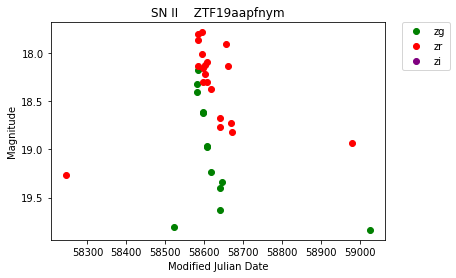

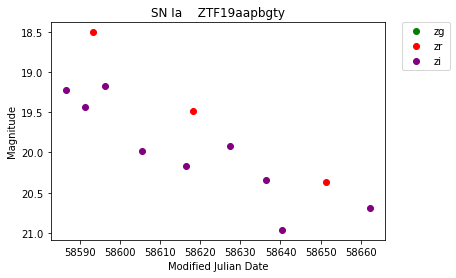

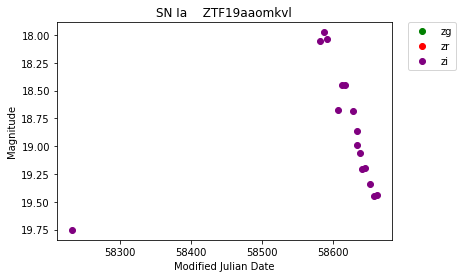

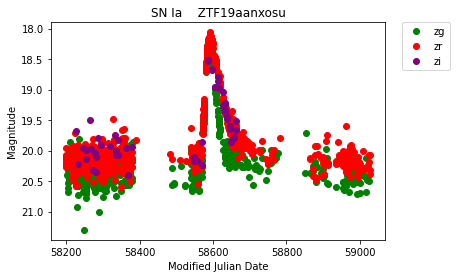

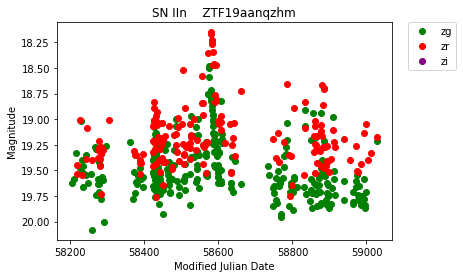

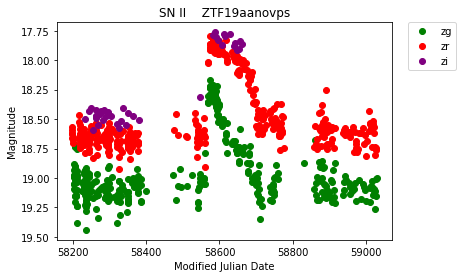

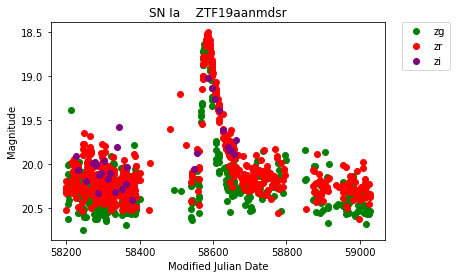

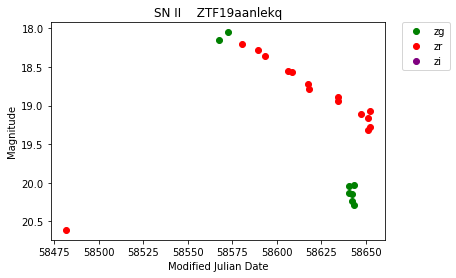

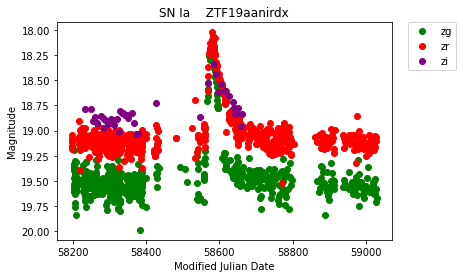

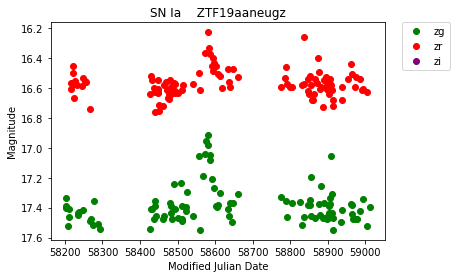

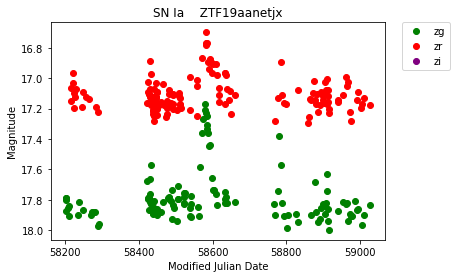

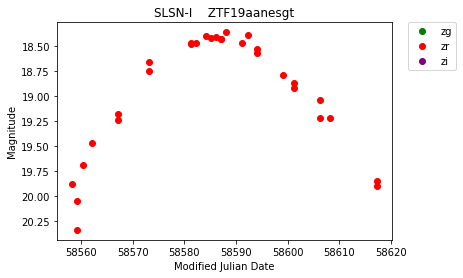

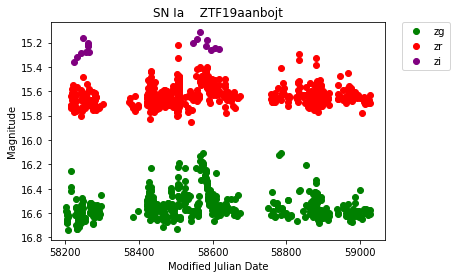

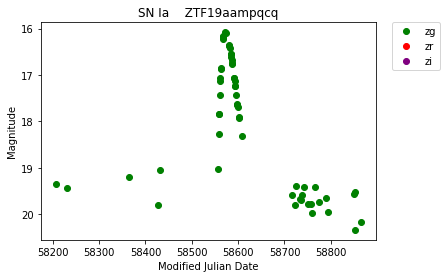

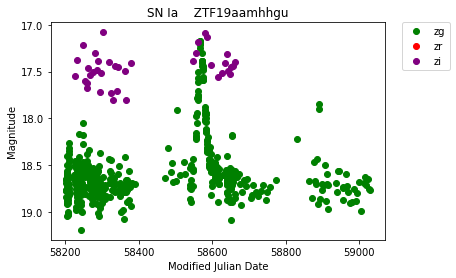

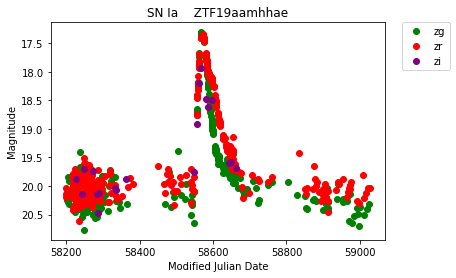

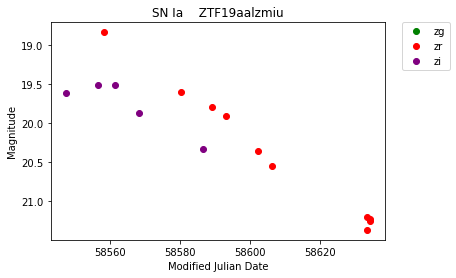

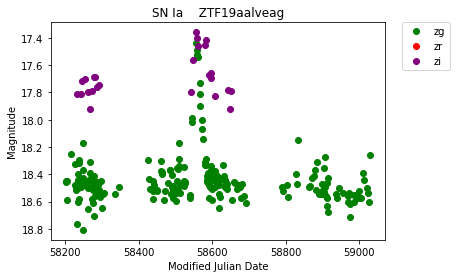

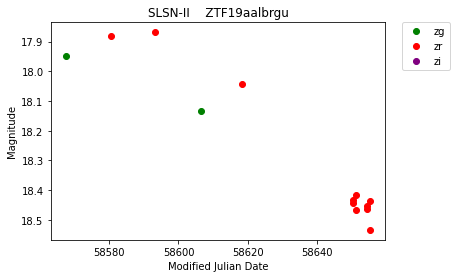

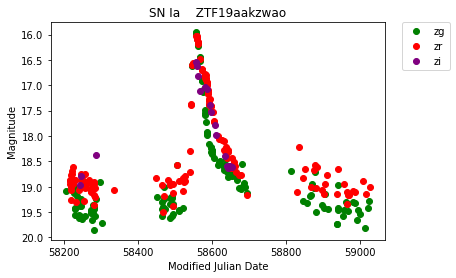

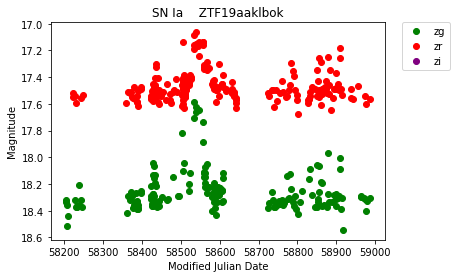

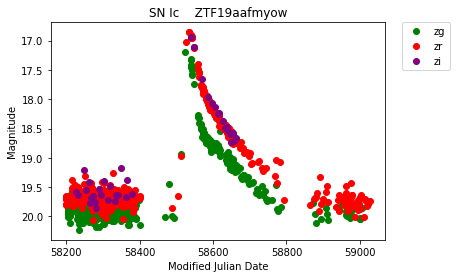

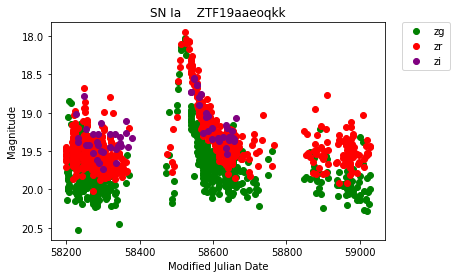

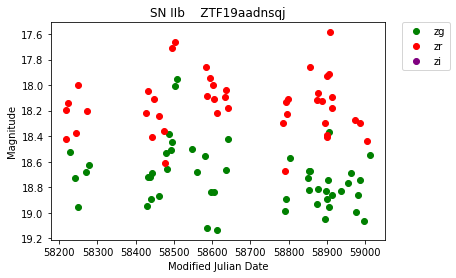

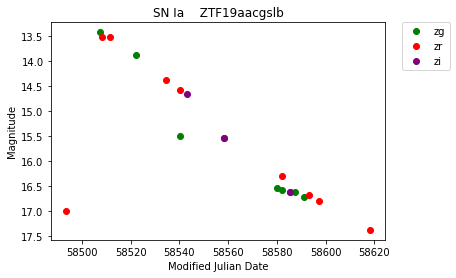

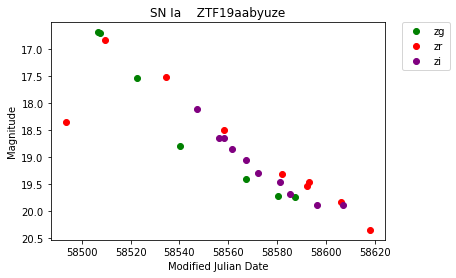

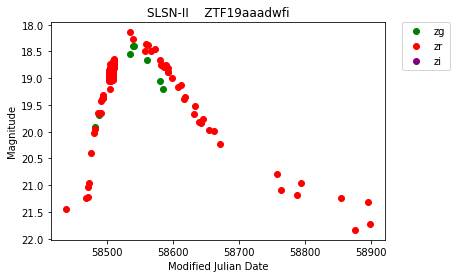

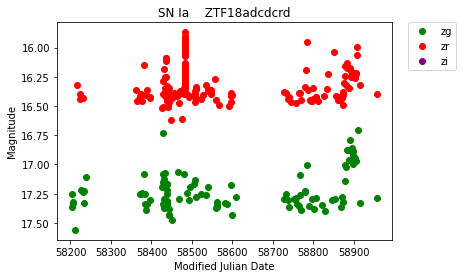

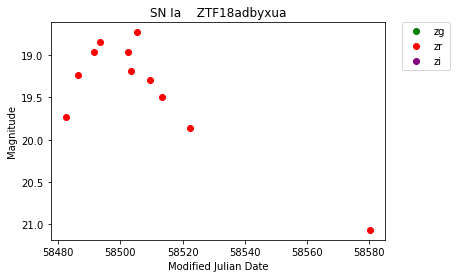

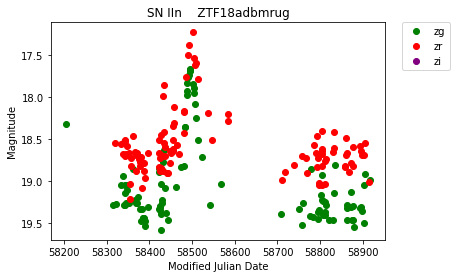

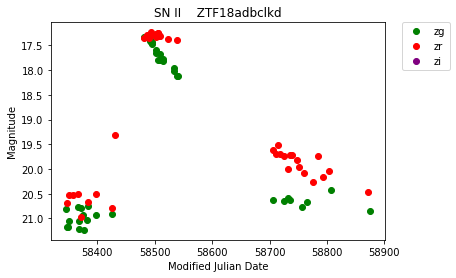

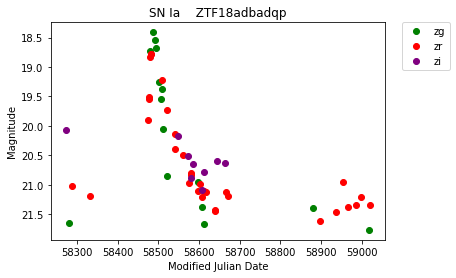

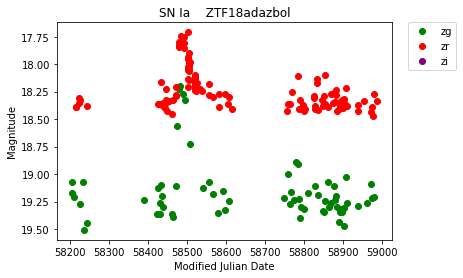

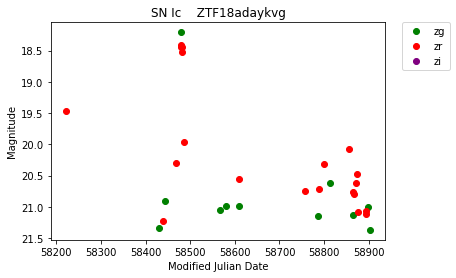

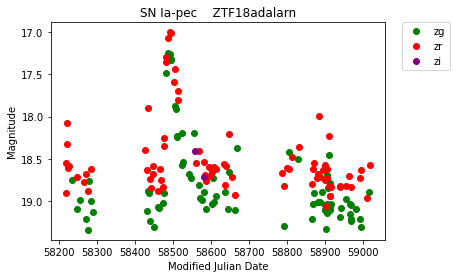

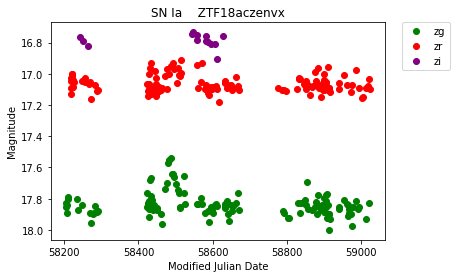

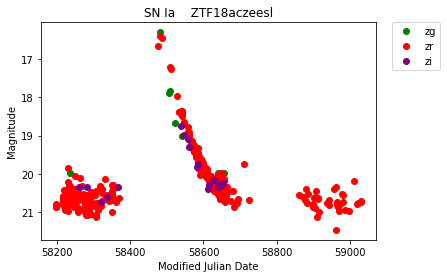

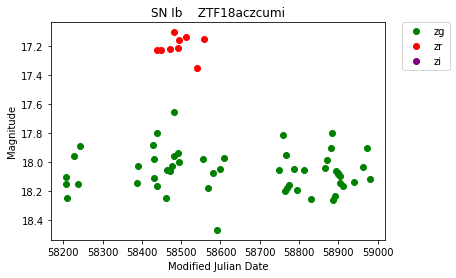

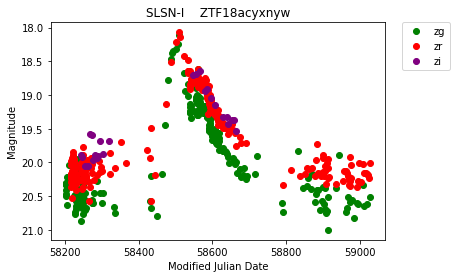

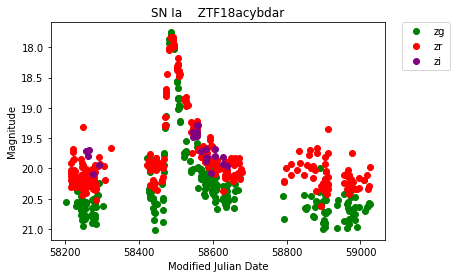

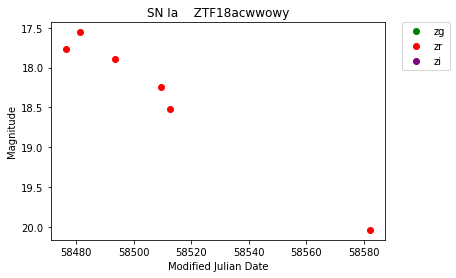

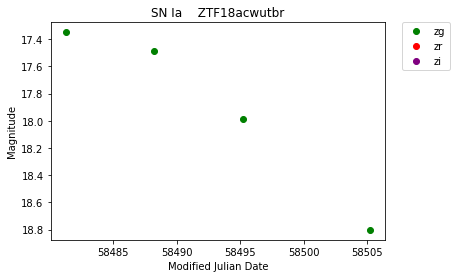

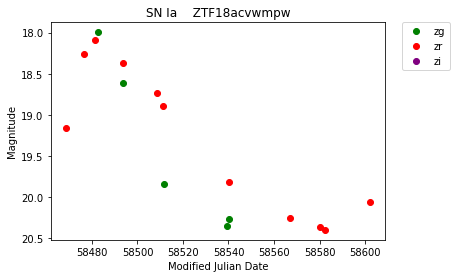

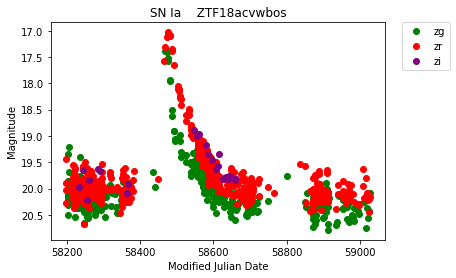

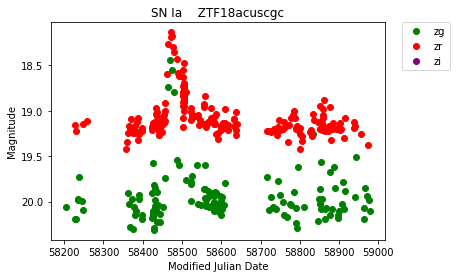

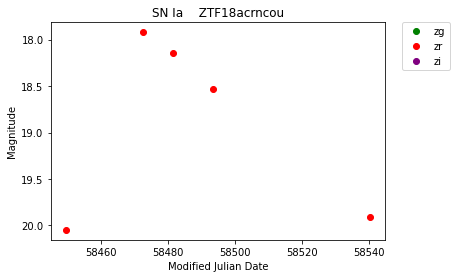

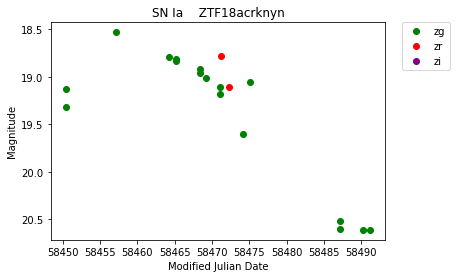

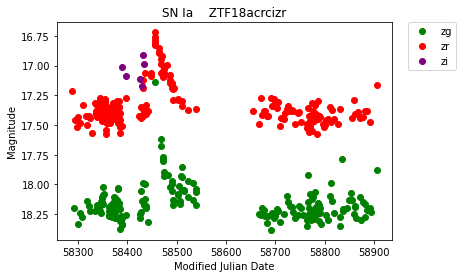

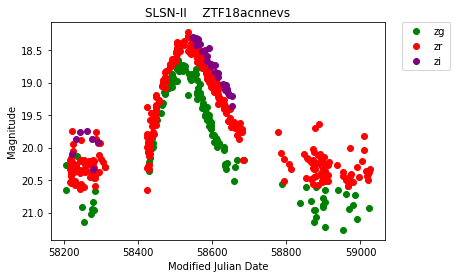

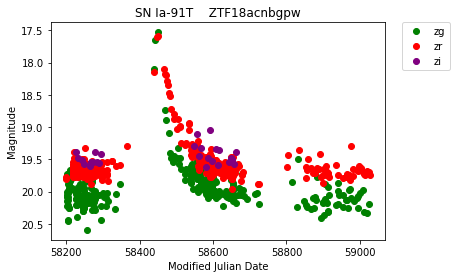

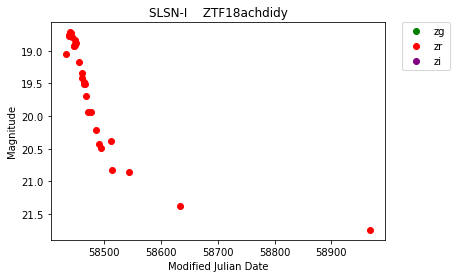

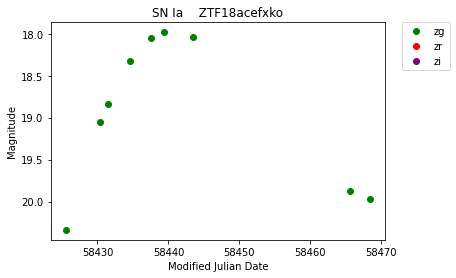

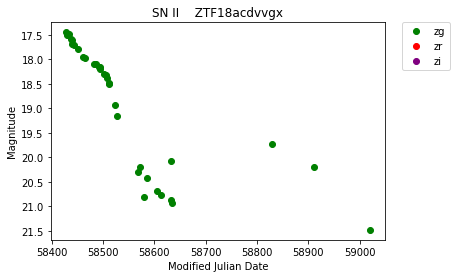

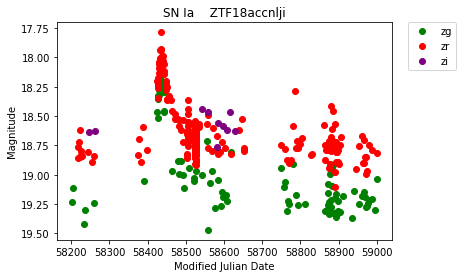

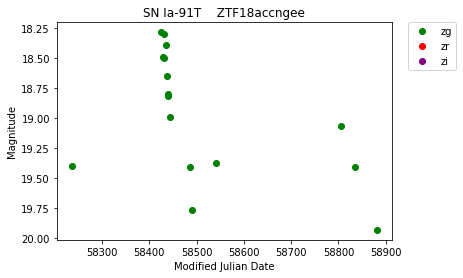

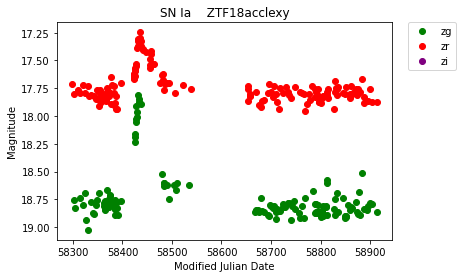

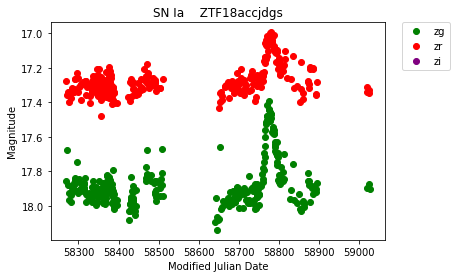

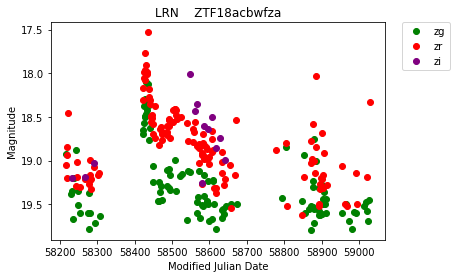

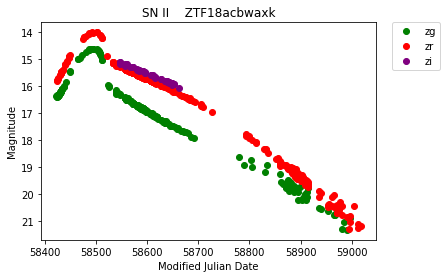

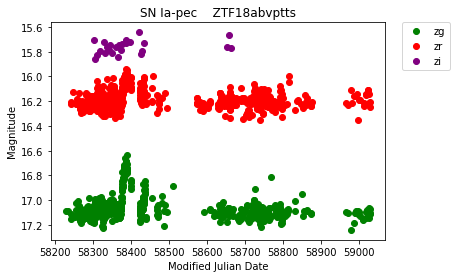

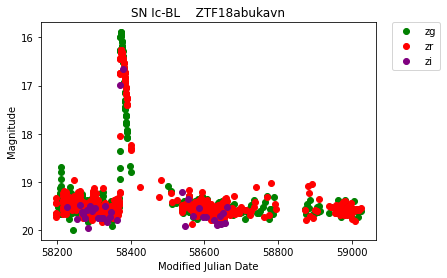

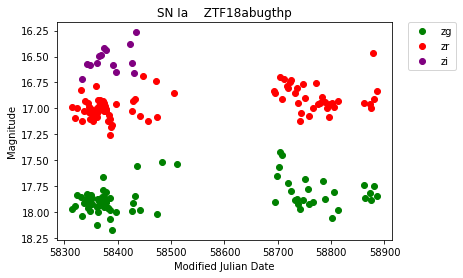

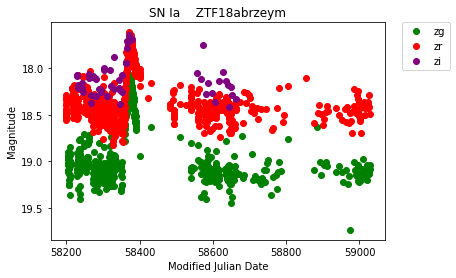

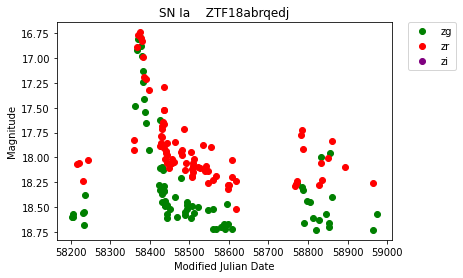

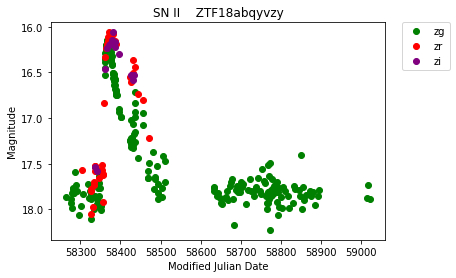

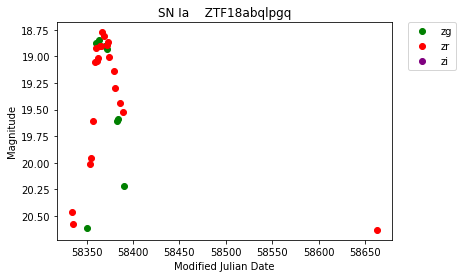

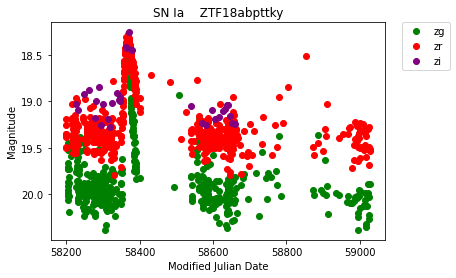

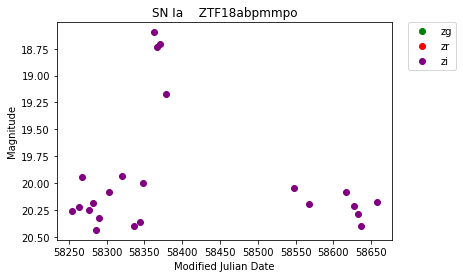

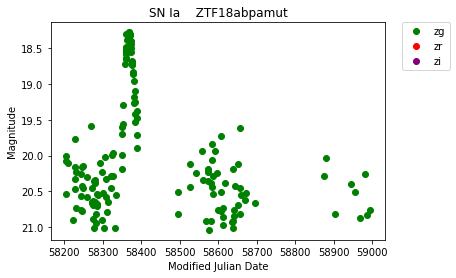

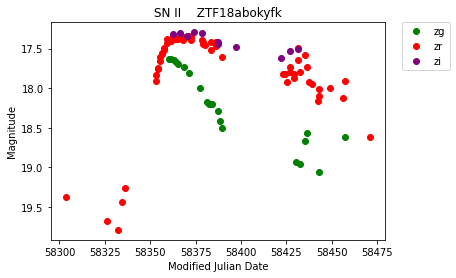

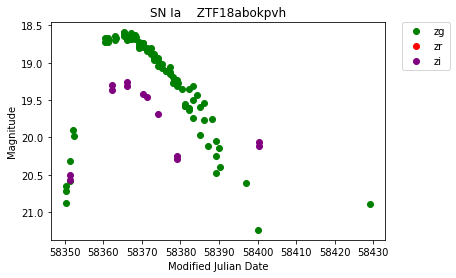

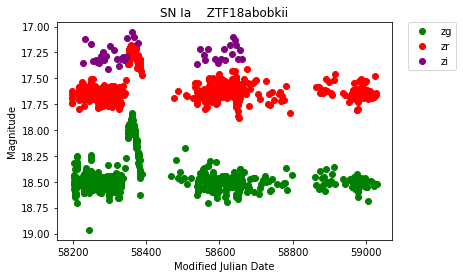

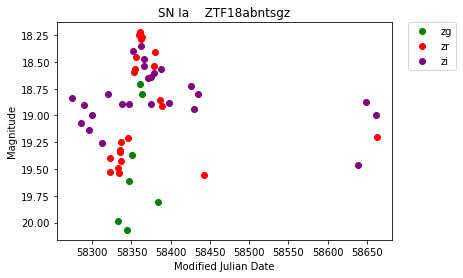

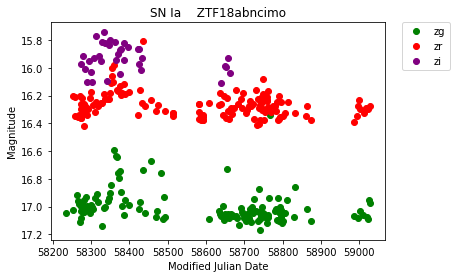

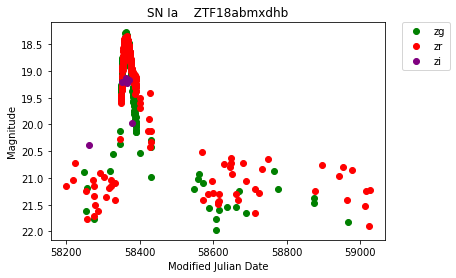

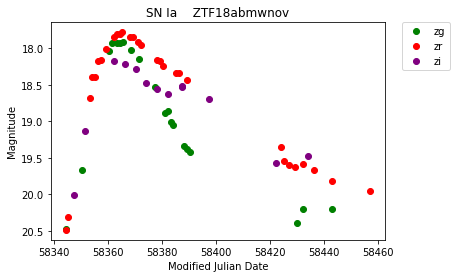

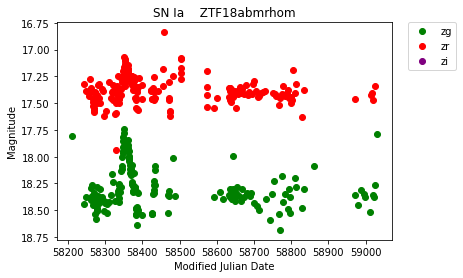

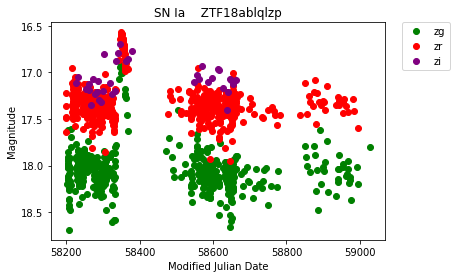

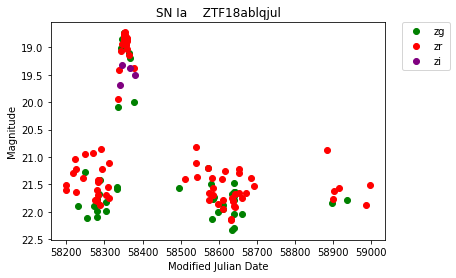

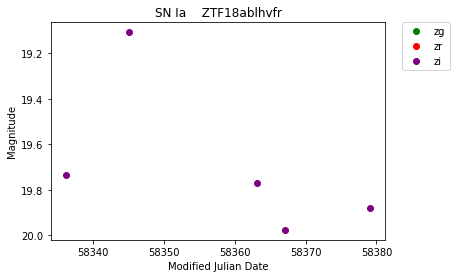

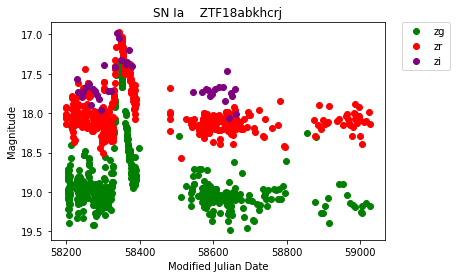

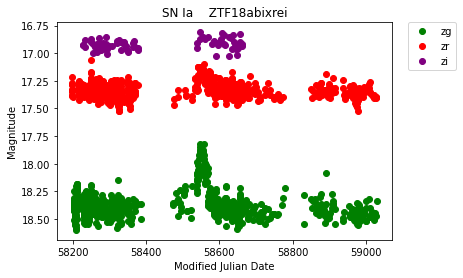

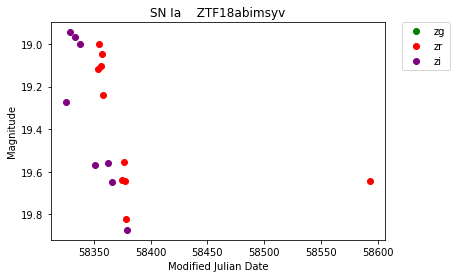

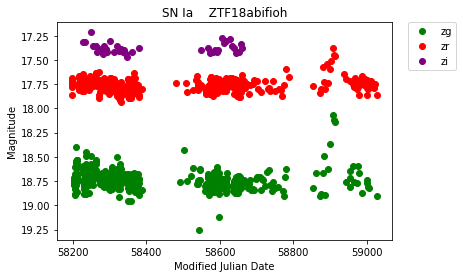

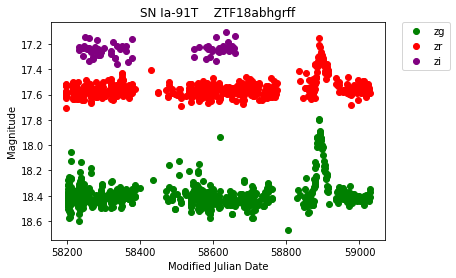

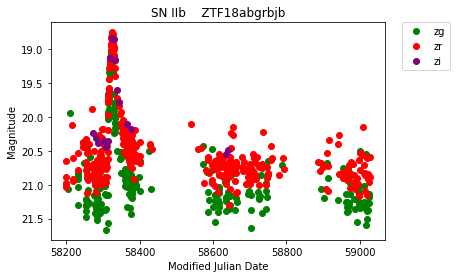

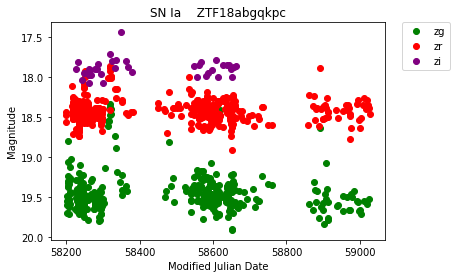

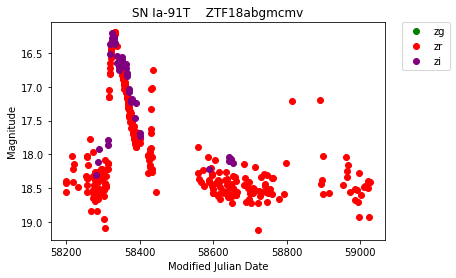

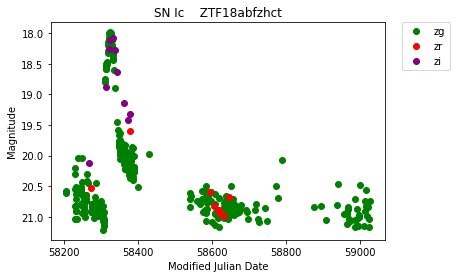

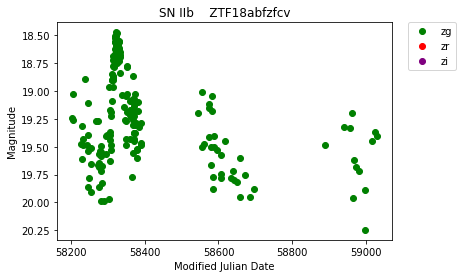

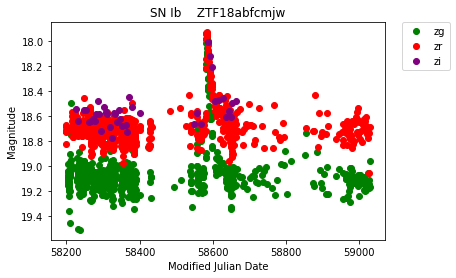

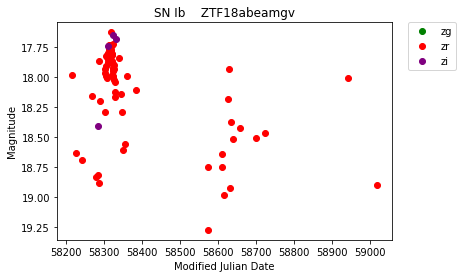

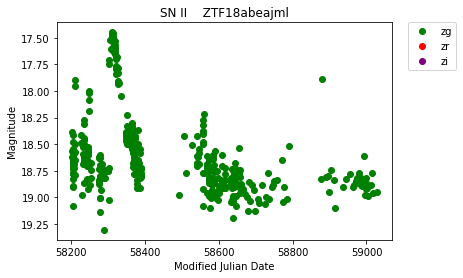

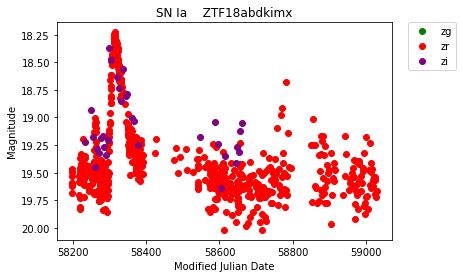

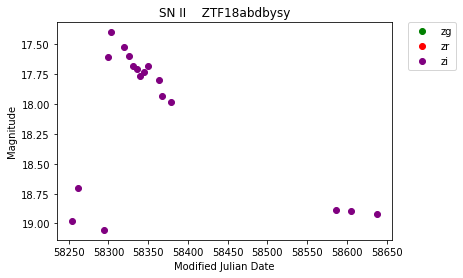

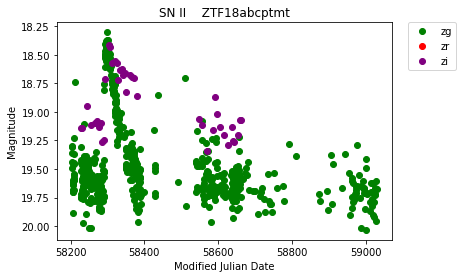

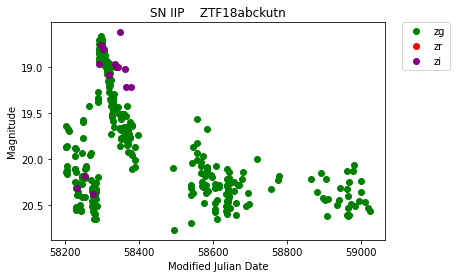

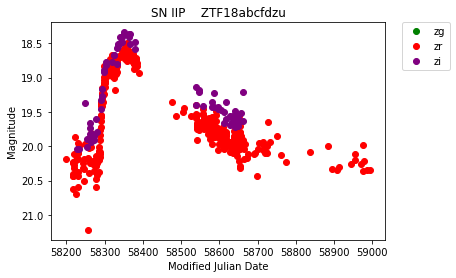

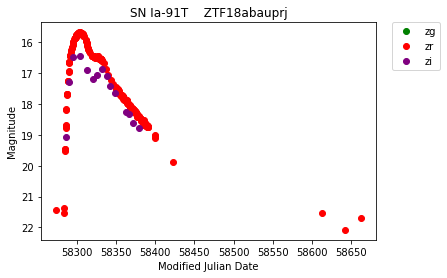

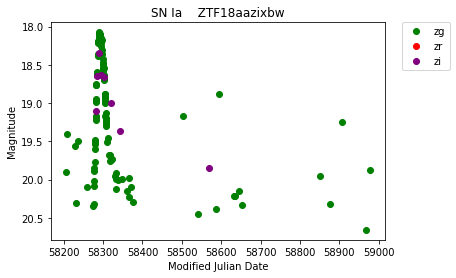

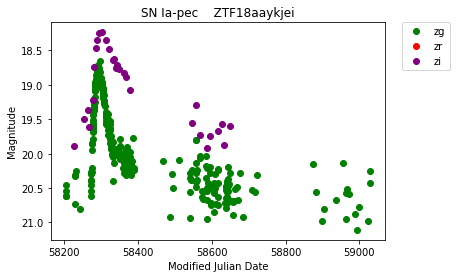

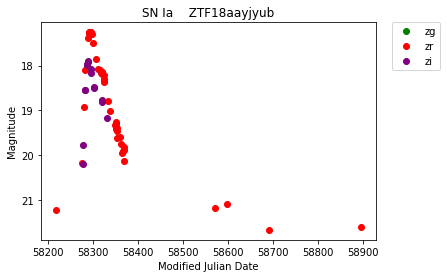

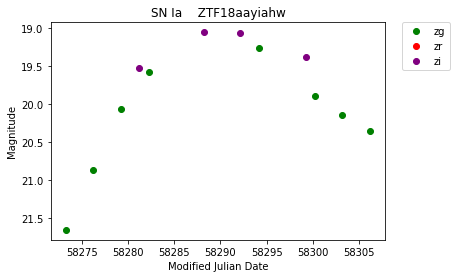

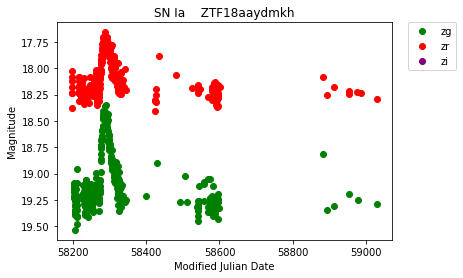

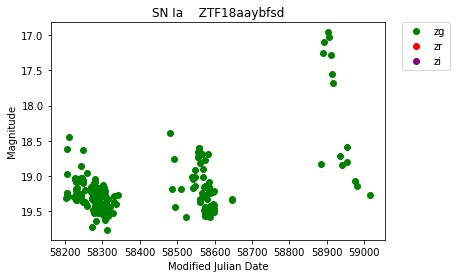

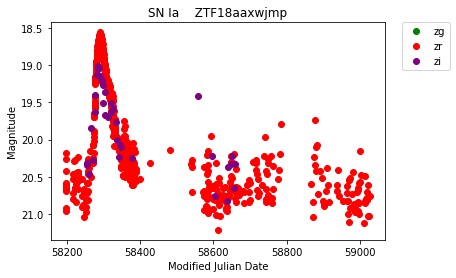

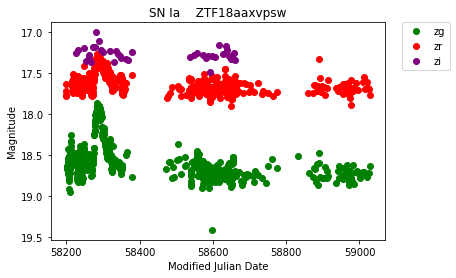

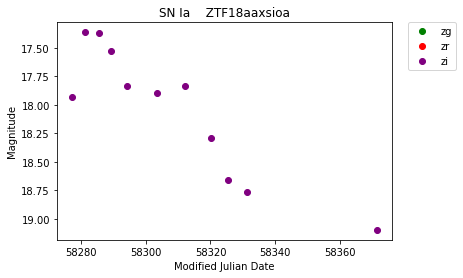

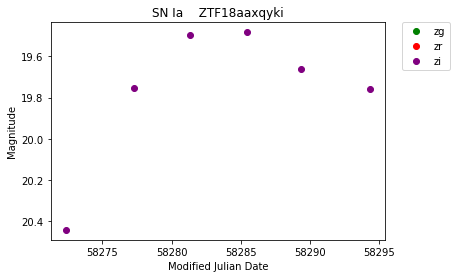

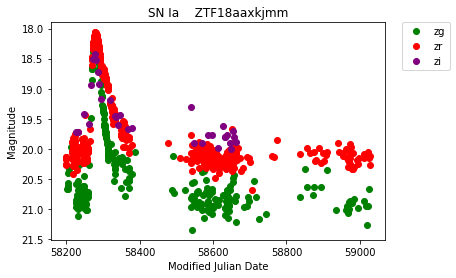

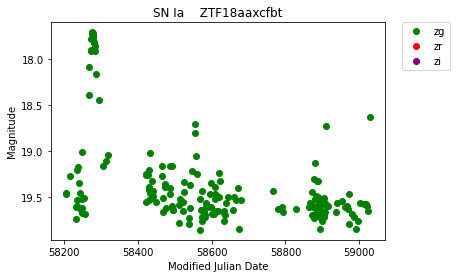

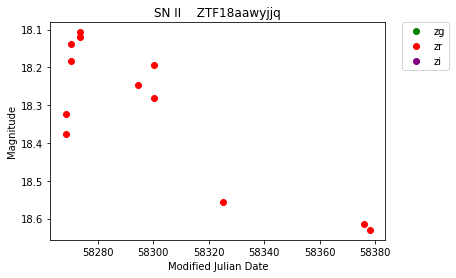

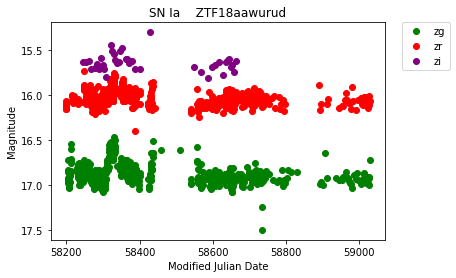

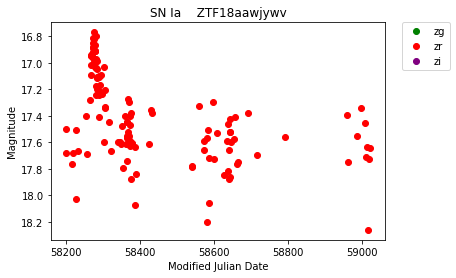

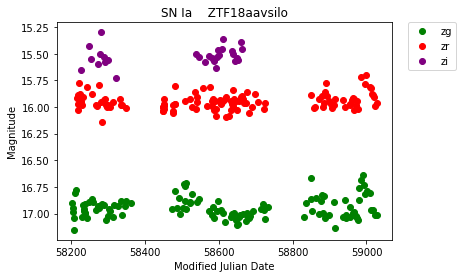

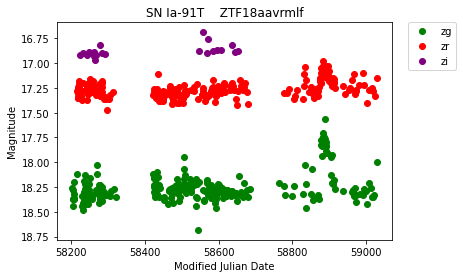

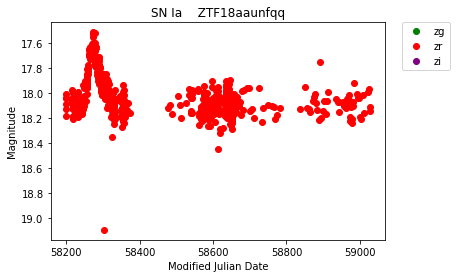

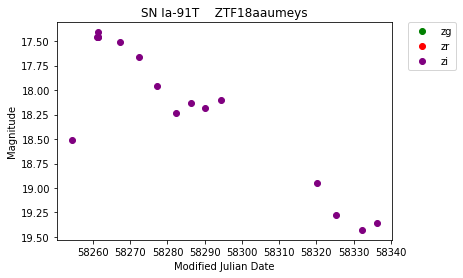

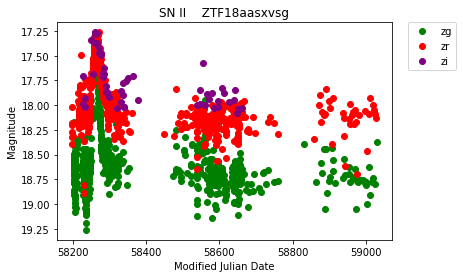

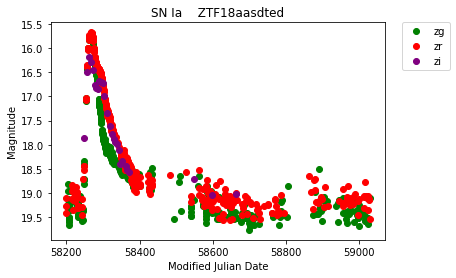

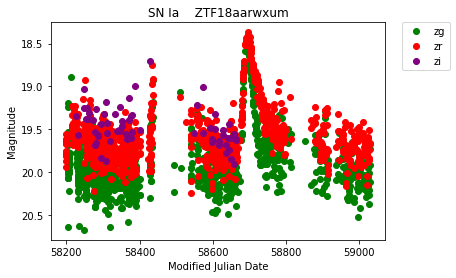

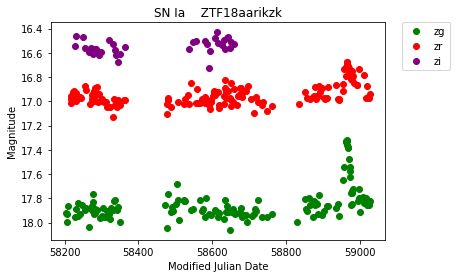

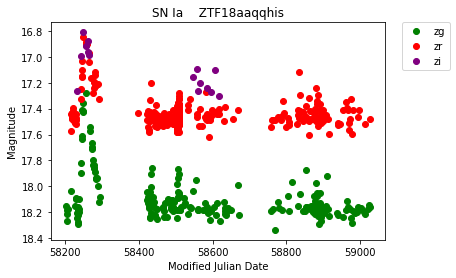

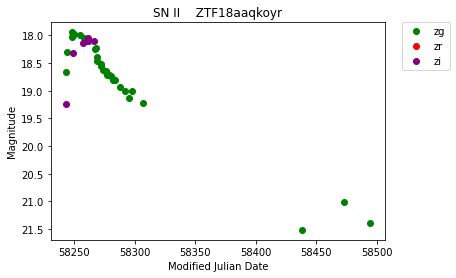

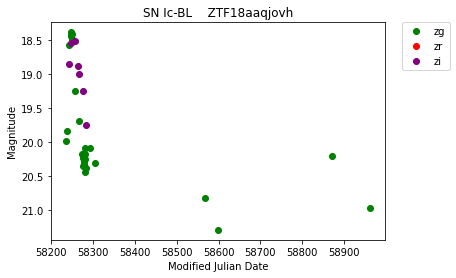

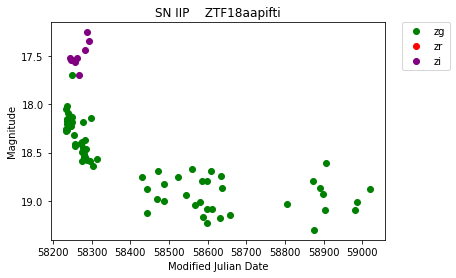

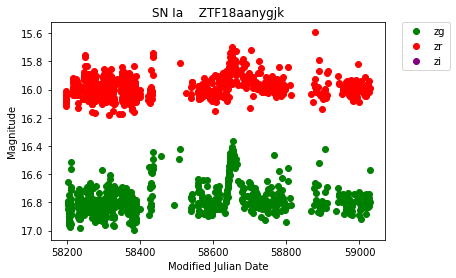

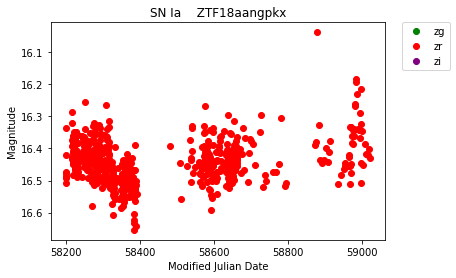

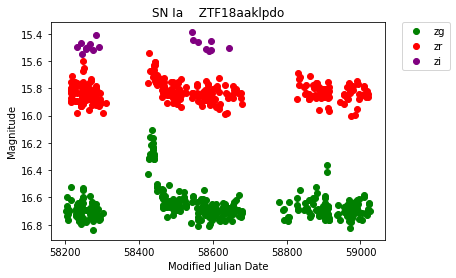

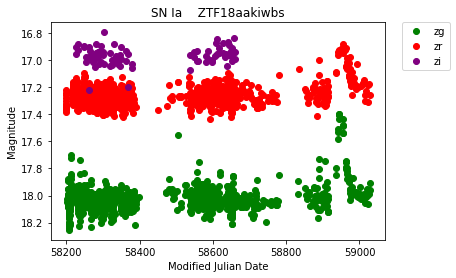

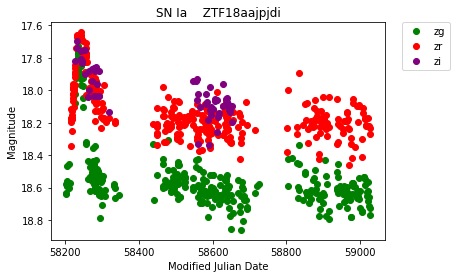

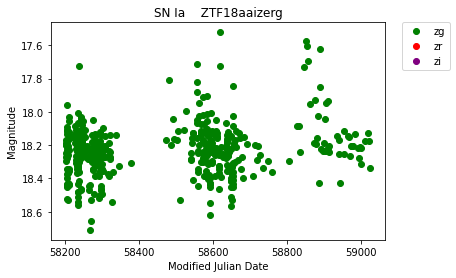

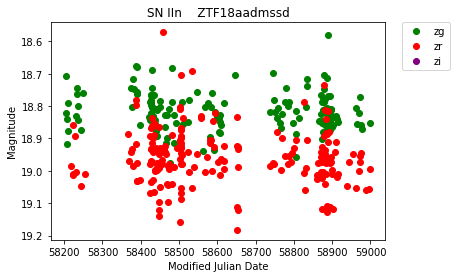

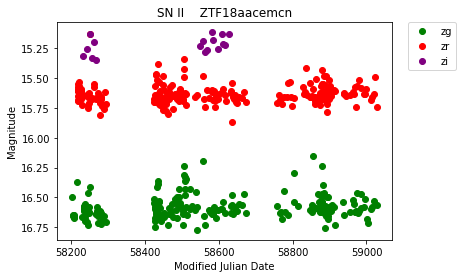

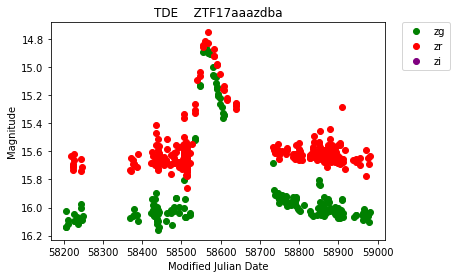

In [142]:
for i in range(len(df_clean)):
    plt.figure()
    plt.gca().invert_yaxis()
    index_in_ztf = numbers[i]
    type_of_supernova = df_ztf[:(index_in_ztf + 1)]['type'].values[index_in_ztf]
    name_of_supernova = df_ztf[:(index_in_ztf + 1)]['ZTFID'].values[index_in_ztf]
    plt.title(type_of_supernova + "    " + name_of_supernova)
    plt.ylabel('Magnitude')
    plt.xlabel('Modified Julian Date')
    green = df_clean[i]['filtercode'] == 'zg'
    red = df_clean[i]['filtercode'] == 'zr'
    infr = df_clean[i]['filtercode'] == 'zi'
    #plt.plot(date_without_matching_g[i], peaks_without_matching_g[i], '*', color = 'gold')
    plt.plot(df_clean[i]['mjd'][green].values, df_clean[i]['mag'][green].values, 'o', color = 'green', label = 'zg')
    plt.plot(df_clean[i]['mjd'][red].values, df_clean[i]['mag'][red].values, 'o', color = 'red', label = 'zr')
    plt.plot(df_clean[i]['mjd'][infr].values, df_clean[i]['mag'][infr].values, 'o', color = 'purple', label = 'zi')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
